## **Data Loading and Cleaning, Data Summary**

In [ ]:
!pip install torch-geometric
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch.nn as nn
import torch_geometric.nn as pyg_nn

In [3]:
data = pd.read_csv('Full_Data.csv')

In [4]:
data.shape

(469364, 22)

In [ ]:
data.head(5)

,salary_from,salary_to,geo_level_2_string,geo_level_4_string,industry_1_name,industry_2_name,occupation_level_1_name,occupation_level_2_name,occupation_level_6_name
0,25886,25886,Noord-Holland,DEN HELDER,Hospitality,Eet- en drinkgelegenheden,"Public Administration, Security & Justice",Safety & Security,Security Supervisor
1,21500,21500,Utrecht,UTRECHT,Information And Communication,Dienstverlenende activiteiten op het gebied va...,Engineering & Technology,Artisanal,Desktop Publishing Specialist
2,74533,74533,Noord-Holland,AMSTERDAM,Information And Communication,Dienstverlenende activiteiten op het gebied va...,Construction,Architecture & Urban Planning,Architect
3,20348,23220,Drenthe,NOORDENVELD,Financial/Insurance,Financi?le instellingen (geen verzekeringen en...,Creative & Linguistic,Creative & Design,Interior Architect
4,26957,26957,Gelderland,APELDOORN,Financial/Insurance,Financi?le instellingen (geen verzekeringen en...,Engineering & Technology,Artisanal,Baking Operator


**Data Cleaning and Log-transformation**

In [5]:
data['salary_from'] = pd.to_numeric(data['salary_from'], errors='coerce')
data['salary_to']   = pd.to_numeric(data['salary_to'],   errors='coerce')

mask = (
    (data['salary_from'] > 10000) &
    (data['salary_from'] <= 500000) &
    (data['salary_from'] <= data['salary_to']) &
    (data['salary_to'] > 10000) &
    (data['salary_to'] <= 500000)
)

data = data[mask]


Add the Average Salary Column: (salary_from + salary_to)/2 and do the log-transformation

In [6]:
data['average'] = (data['salary_from']+ data['salary_to'])/2
data['log_average'] = np.log1p(data['average'])

In [7]:
data.shape

(466581, 24)

In [ ]:
summary = {
    'field_name': [],
    'non_null_count': [],
    'distinct_count': []
}

for col in data.columns:
    summary['field_name'].append(col)
    summary['non_null_count'].append(data[col].notnull().sum())
    summary['distinct_count'].append(data[col].nunique(dropna=True))

df_summary = pd.DataFrame(summary)

print(df_summary)

                 field_name  non_null_count  distinct_count
0               salary_from          699972            7466
1                 salary_to          699972            7957
2        geo_level_2_string          699904              12
3        geo_level_4_string          662045             462
4           industry_1_name          699972              21
5           industry_2_name          699149              78
6   occupation_level_1_name          699971              14
7   occupation_level_2_name          699971              36
8   occupation_level_6_name          578552            2312
9                   average          699972           13353
10              log_average          699972           13353


## **EDA**

### **Average Salary Distribution**

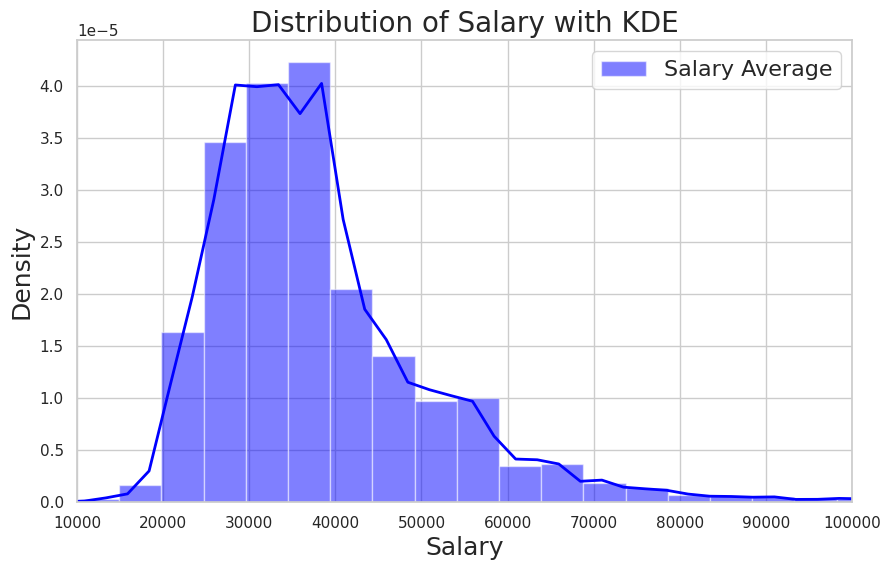

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.hist(data['average'], bins=100, alpha=0.5, color='blue', label='Salary Average', density=True)
sns.kdeplot(data['average'], color='blue', linewidth=2)
plt.xlabel('Salary', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Salary with KDE', fontsize=20)
plt.xlim(10000,100000)
plt.legend(fontsize=16)
plt.show()

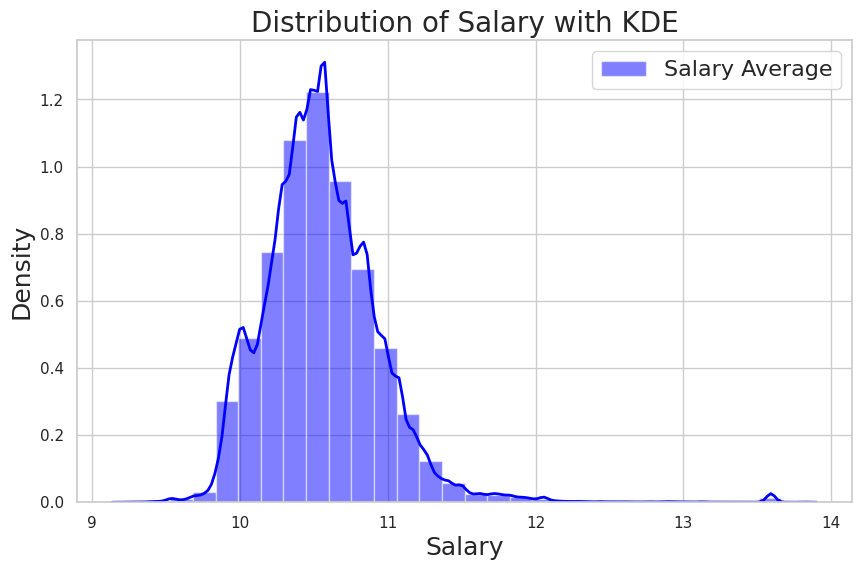

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.hist(data['log_average'], bins=30, alpha=0.5, color='blue', label='Salary Average', density=True)
sns.kdeplot(data['log_average'], color='blue', linewidth=2)

plt.xlabel('Log-Salary', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Distribution of Log-Salary with KDE', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [ ]:
data.columns

Index(['salary_from', 'salary_to', 'geo_level_1_string', 'geo_level_2_string',
       'geo_level_4_string', 'industry_level_1', 'industry_level_2',
       'occupation_level_1', 'occupation_level_2', 'occupation_level_3',
       'occupation_level_4', 'occupation_level_5', 'occupation_level_6',
       'isco_code', 'salary_category', 'industry_1_name', 'industry_2_name',
       'occupation_level_1_name', 'occupation_level_2_name',
       'occupation_level_3_name', 'occupation_level_4_name',
       'occupation_level_6_name', 'average'],
      dtype='object')

### **Salary Grouped by Different Levels of Regions**

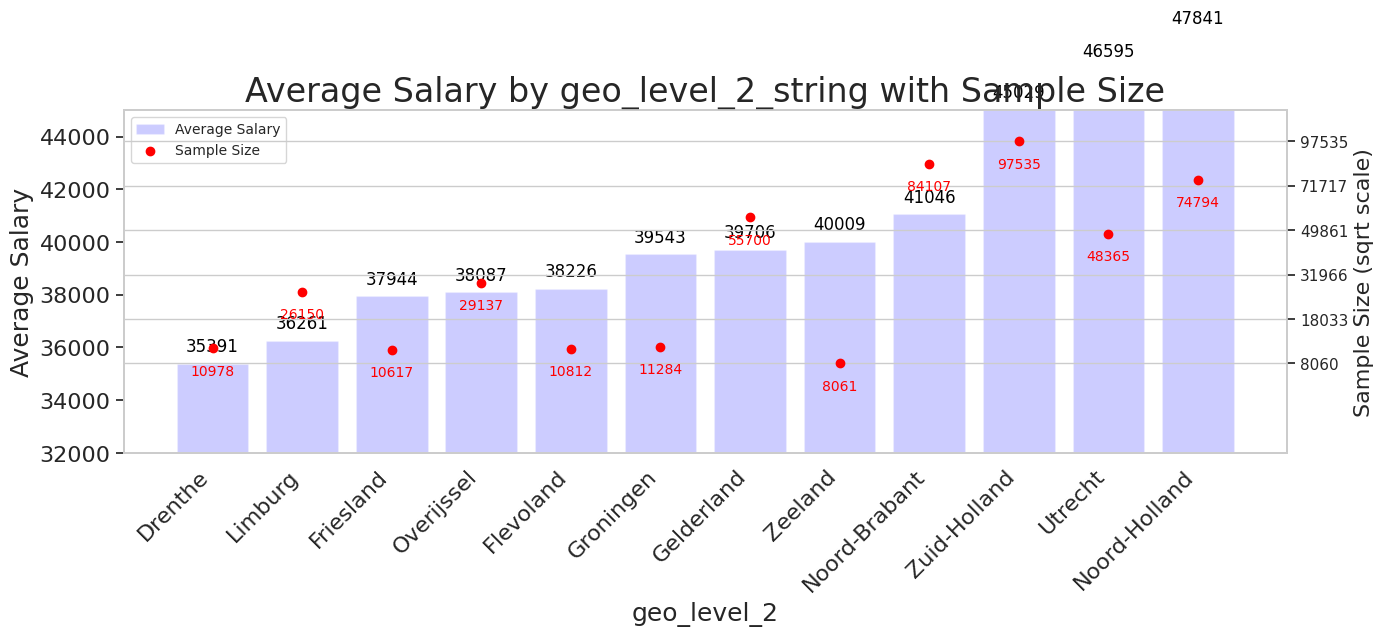

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_geo2 = data.groupby('geo_level_2_string')['average'].mean()
count_by_geo2 = data.groupby('geo_level_2_string')['average'].count()

avg_salary_by_geo2_sorted = avg_salary_by_geo2.sort_values()
count_by_geo2_sorted = count_by_geo2.loc[avg_salary_by_geo2_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,7))

bars = ax1.bar(avg_salary_by_geo2_sorted.index.astype(str),
               avg_salary_by_geo2_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary', fontsize=18)
ax1.set_xlabel('geo_level_2', fontsize=18)
ax1.set_ylim(32000, 45000)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_title('Average Salary by geo_level_2_string with Sample Size', fontsize=24)
ax1.grid(False)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 300, f'{height:.0f}',
             ha='center', va='bottom', fontsize=12, color='black')

ax2 = ax1.twinx()

counts = count_by_geo2_sorted.values
x = np.arange(len(avg_salary_by_geo2_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)
ax2.set_ylabel('Sample Size (sqrt scale)', fontsize=16)
ax2.set_ylim(0, y_positions.max() * 1.1)

def sqrt_tick_formatter(val, pos):
    return f'{int(val**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos - (y_positions.max() * 0.05), f'{count}', ha='center', va='top', fontsize=10, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_geo2_sorted.index.astype(str), rotation=45, ha='right', fontsize=16)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


<ipython-input-15-c9e8c073061b>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')


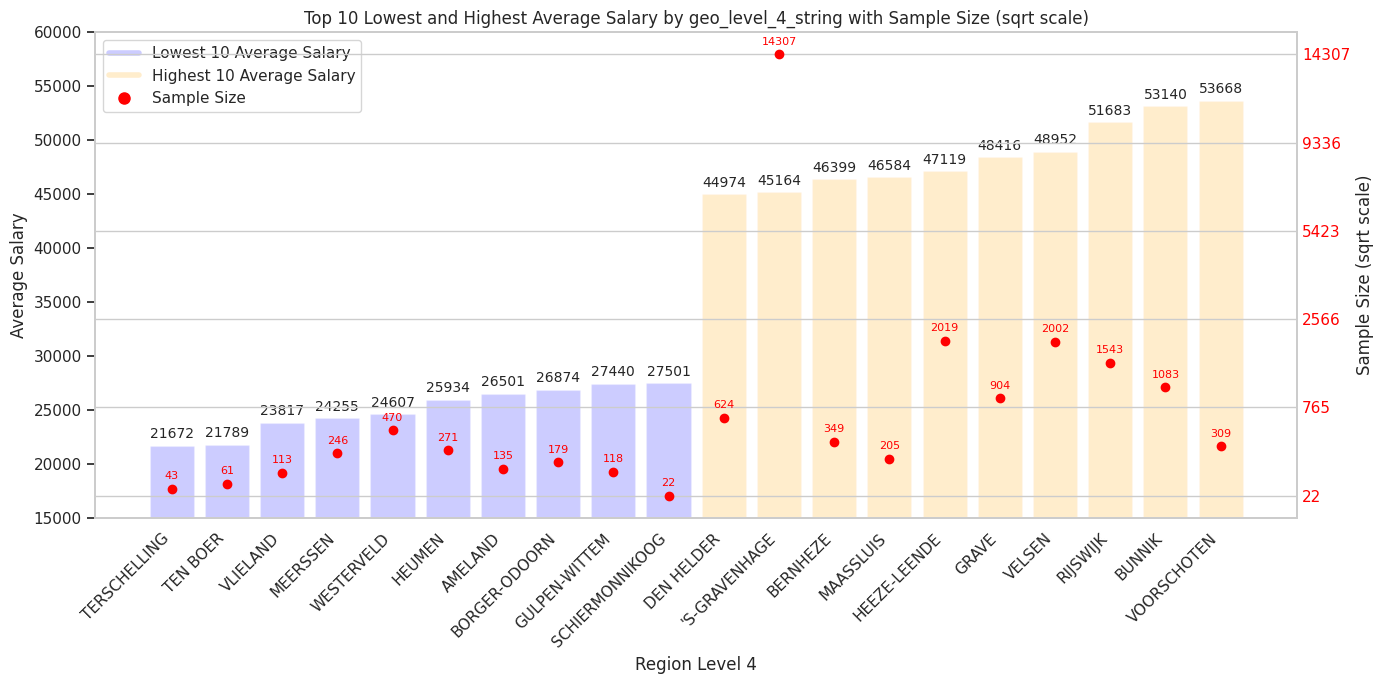

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算平均薪资和样本数
avg_salary_by_region_4 = data.groupby('geo_level_4_string')['average'].mean()
sample_size_by_region_4 = data.groupby('geo_level_4_string')['average'].count()

# 取最低10和最高10并排序
lowest_10 = avg_salary_by_region_4.nsmallest(10).sort_values()
highest_10 = avg_salary_by_region_4.nlargest(10).sort_values()

combined_avg = pd.concat([lowest_10, highest_10])
combined_sample = pd.concat([
    sample_size_by_region_4.loc[lowest_10.index],
    sample_size_by_region_4.loc[highest_10.index]
])

fig, ax1 = plt.subplots(figsize=(14,7))

# 取消网格
ax1.grid(False)

# 画柱状图，透明度0.2
bars = ax1.bar(combined_avg.index.astype(str),
               combined_avg.values,
               color=['blue']*10 + ['orange']*10,
               alpha=0.2,
               label='Average Salary')

ax1.set_ylabel('Average Salary')
ax1.set_xlabel('Region Level 4')
ax1.set_ylim(15000, 60000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')
ax1.set_title('Top 10 Lowest and Highest Average Salary by geo_level_4_string with Sample Size (sqrt scale)')

# 显示平均薪资数值标签（柱子顶部）
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 400, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10)

# 右侧y轴画样本数量散点图，平方根缩放
ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)')
counts = combined_sample.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后的数）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='red')

# 不显示右侧刻度线长度
ax2.tick_params(axis='y', which='both', length=0)

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos+2, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')

# 图例合并
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, alpha=0.2, label='Lowest 10 Average Salary'),
    Line2D([0], [0], color='orange', lw=4, alpha=0.2, label='Highest 10 Average Salary'),
    Line2D([0], [0], marker='o', color='red', label='Sample Size', lw=0, markersize=8)
]
ax1.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()




### **Salary Grouped by Different Levels of Industries**

<ipython-input-16-61b1a05e959f>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')


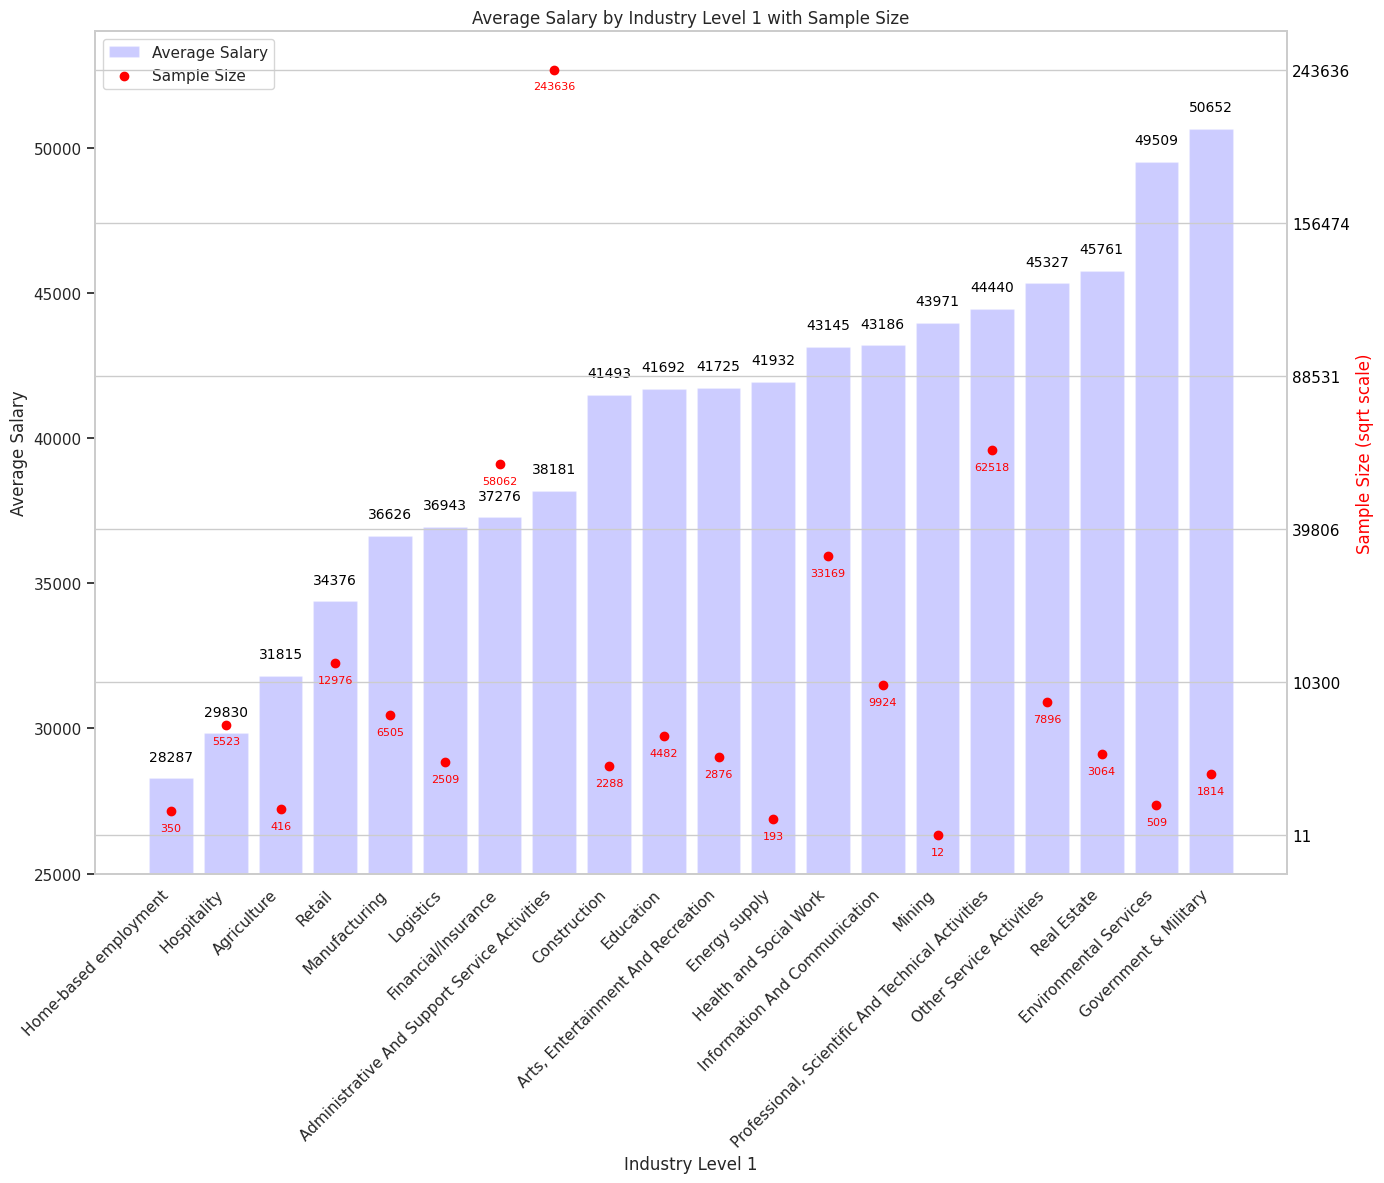

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

avg_salary_by_industry_1 = data.groupby('industry_1_name')['average'].mean()
count_by_industry_1 = data.groupby('industry_1_name')['average'].count()

# 排序保持一致
avg_salary_by_industry_1_sorted = avg_salary_by_industry_1.sort_values()
count_by_industry_1_sorted = count_by_industry_1.loc[avg_salary_by_industry_1_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,12))

# 画柱状图（平均薪资），透明度设为0.2
bars = ax1.bar(avg_salary_by_industry_1_sorted.index.astype(str),
               avg_salary_by_industry_1_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary')
ax1.set_xlabel('Industry Level 1')
ax1.set_ylim(25000, 54000)
ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')
ax1.set_title('Average Salary by Industry Level 1 with Sample Size')

# 取消网格
ax1.grid(False)

# 添加平均薪资标签，稍微往上偏移，避免和样本数标签重叠
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 500, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10, color='black')

# 创建第二个y轴，画样本数，用平方根缩放
ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')

counts = count_by_industry_1_sorted.values
x = np.arange(len(avg_salary_by_industry_1_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

# 生成合适的刻度（取平方根后，均匀分布）
ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='black')

# 不显示右侧y轴刻度线
ax2.tick_params(axis='y', which='both', length=0)

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos-14, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_industry_1_sorted.index.astype(str), rotation=45, ha='right')

# 图例合并显示
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

**Top 10 Lowest and Highest Average Salary by Industry Level 2**

<ipython-input-17-5553421ba755>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')


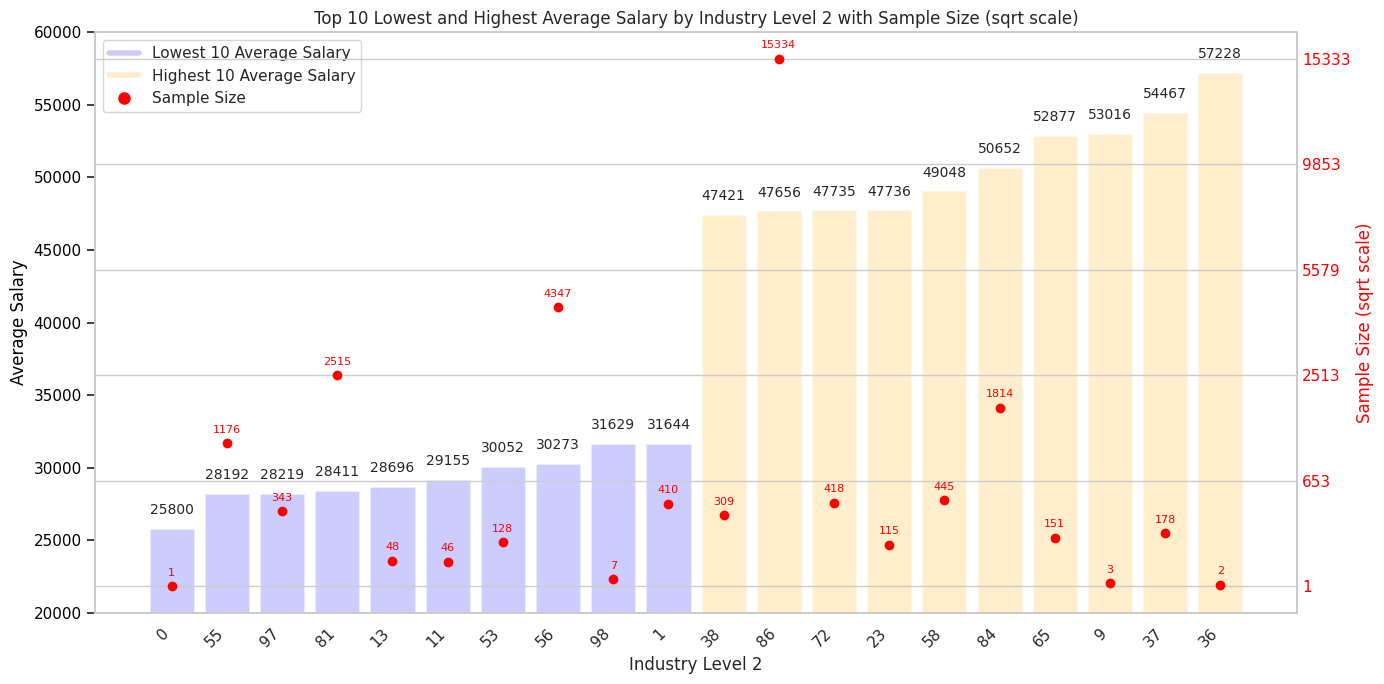

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

avg_salary = data.groupby('industry_level_2')['average'].mean()
count_data = data.groupby('industry_level_2')['average'].count()

lowest_10 = avg_salary.nsmallest(10).sort_values()
highest_10 = avg_salary.nlargest(10).sort_values()
combined_avg = pd.concat([lowest_10, highest_10])
combined_count = count_data.loc[combined_avg.index]

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.grid(False)

colors = ['blue']*10 + ['orange']*10
bars = ax1.bar(combined_avg.index.astype(str), combined_avg.values, color=colors, alpha=0.2)
ax1.set_xlabel('Industry Level 2')
ax1.set_ylabel('Average Salary', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(20000, 60000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')
ax1.set_title('Top 10 Lowest and Highest Average Salary by Industry Level 2 with Sample Size (sqrt scale)')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 800, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')

counts = combined_count.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])
ax2.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', which='both', length=0)

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos+2, f'{count}', ha='center', va='bottom', fontsize=8, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, alpha=0.2, label='Lowest 10 Average Salary'),
    Line2D([0], [0], color='orange', lw=4, alpha=0.2, label='Highest 10 Average Salary'),
    Line2D([0], [0], marker='o', color='red', label='Sample Size', lw=0, markersize=8)
]
ax1.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()




### **Salary Grouped by Different Levels of Occupations**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_occ1 = data.groupby('occupation_level_1_name')['average'].mean()
count_by_occ1 = data.groupby('occupation_level_1_name')['average'].count()

avg_salary_by_occ1_sorted = avg_salary_by_occ1.sort_values()
count_by_occ1_sorted = count_by_occ1.loc[avg_salary_by_occ1_sorted.index]

fig, ax1 = plt.subplots(figsize=(14,7))

bars = ax1.bar(avg_salary_by_occ1_sorted.index.astype(str),
               avg_salary_by_occ1_sorted.values,
               alpha=0.2,
               label='Average Salary',
               color='blue')

ax1.set_ylabel('Average Salary', fontsize=10)
ax1.set_xlabel('Occupation Level 1', fontsize=10)
ax1.set_ylim(22000, 52000)
ax1.set_xticklabels(avg_salary_by_occ1_sorted.index.astype(str), rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_title('Average Salary by Occupation Level 1 with Sample Size', fontsize=16)

ax1.grid(False)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 500, f'{height:.0f}',
             ha='center', va='bottom', fontsize=12, color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', fontsize=10)
ax2.tick_params(axis='y', labelsize=8)

counts = count_by_occ1_sorted.values
x = np.arange(len(avg_salary_by_occ1_sorted))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_ylim(0, y_positions.max()*1.1)  # y轴从0开始
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos*1.05, f'{count}', ha='center', va='bottom', fontsize=10, color='red')

ax1.set_xticks(x)
ax1.set_xticklabels(avg_salary_by_occ1_sorted.index.astype(str), rotation=45, ha='right', fontsize=8)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

avg_salary_by_occ6 = data.groupby('occupation_level_6_name')['average'].mean()
count_by_occ6 = data.groupby('occupation_level_6')['average'].count()

lowest_10 = avg_salary_by_occ6.nsmallest(10).sort_values()
highest_10 = avg_salary_by_occ6.nlargest(10).sort_values()

combined_avg = pd.concat([lowest_10, highest_10])
combined_count = count_by_occ6.loc[combined_avg.index]

fig, ax1 = plt.subplots(figsize=(14,7))

colors = ['blue']*10 + ['orange']*10
bars = ax1.bar(combined_avg.index.astype(str), combined_avg.values, color=colors, alpha=0.2)
ax1.set_xlabel('Occupation Level 6')
ax1.set_ylabel('Average Salary', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(20000, 100000)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right', fontsize=8)
ax1.set_title('Top 10 Lowest and Highest Average Salary by Occupation Level 6 with Sample Size')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 800, f'{height:.0f}',
             ha='center', va='bottom', fontsize=10, color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Sample Size (sqrt scale)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

counts = combined_count.values
x = np.arange(len(combined_avg))
y_positions = np.sqrt(counts)

ax2.scatter(x, y_positions, color='red', label='Sample Size', zorder=5)

# 自定义y轴刻度显示原始样本数（平方后）
def sqrt_tick_formatter(x, pos):
    return f'{int(x**2)}'

ticks = np.linspace(y_positions.min(), y_positions.max(), num=6)
ax2.set_ylim(0, y_positions.max()*1.1)  # y轴从0开始
ax2.set_yticks(ticks)
ax2.set_yticklabels([sqrt_tick_formatter(t, None) for t in ticks])

# 样本数标签，稍往上偏移避免遮挡散点
for i, (pos, count) in enumerate(zip(y_positions, counts)):
    ax2.text(i, pos*1.05, f'{count}', ha='center', va='bottom', fontsize=10, color='red')

# 设置x轴刻度和标签
ax1.set_xticks(x)
ax1.set_xticklabels(combined_avg.index.astype(str), rotation=45, ha='right', fontsize=8)

# 图例合并显示
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


## **Creating Graphs for Each Domain**

**Creating Nodes, Hierarchical Edges and Similarity Edges**

**Hierarchical edges:** The vertical hierarchical relationship contained in the same domain in a single job posting record (such as "province-city" or "occupation category-occupation subcategory")

**Similarity Edges:** For all nodes of the same level (e.g. all cities), the semantic cosine similarity between different attribute values (e.g. Amsterdam and Rotterdam) is calculated, and is used as the weight of this edge. In order to prevent the graph from becoming too dense (fully connected), we set a low "noise" threshold to ignore those connections that are almost irrelevant.



In [ ]:
!pip install sentence-transformers # Text Embedding Framework

In [9]:
import pandas as pd
import networkx as nx
from time import time
from sentence_transformers import SentenceTransformer, util
import torch

In [48]:
MIN_WEIGHT_THRESHOLD_REGION = 0.6 ## Filter out almost irrelevant connections
MIN_WEIGHT_THRESHOLD_OCCUPATION = 0.5
MIN_WEIGHT_THRESHOLD_INDUSTRY = 0.6

**Region Graph**

In [49]:
start_time_region = time()
G_region = nx.Graph()
node_mapping_region = {}
node_index_region = 0

# Region Graph
print("Processing Region Graph...")
print("Step 1: Building hierarchical edges")
start_region_hierarchical = time()
for index, row in data.iterrows():
    geo_l2_node = row['geo_level_2_string']
    geo_l4_node = row['geo_level_4_string']
    if pd.notna(geo_l2_node) and geo_l2_node not in node_mapping_region:
        node_mapping_region[geo_l2_node] = node_index_region
        G_region.add_node(geo_l2_node, type='geo_level_2', id=node_index_region)
        node_index_region += 1

    if pd.notna(geo_l4_node) and geo_l4_node not in node_mapping_region:
        node_mapping_region[geo_l4_node] = node_index_region
        G_region.add_node(geo_l4_node, type='geo_level_4', id=node_index_region)
        node_index_region += 1

    # Add hierarchical edges
    if pd.notna(geo_l2_node) and pd.notna(geo_l4_node):
        G_region.add_edge(geo_l2_node, geo_l4_node)
end_region_hierarchical = time()
print(f"hierarchical edges built in {end_region_hierarchical-start_region_hierarchical:.1f} seconds.")

print("nStep 2: Building similarity edges")
start_region_similarity = time()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


# --- 对每个层级（城市和省份）都执行此逻辑 ---
for level_name, level_type in [('city', 'geo_level_4'), ('province', 'geo_level_2')]:

    nodes_to_compare = [node for node, attr in G_region.nodes(data=True) if attr.get('type') == level_type]
    print(f"\nFound {len(nodes_to_compare)} {level_name} nodes to compare.")

    if len(nodes_to_compare) > 1:
        print(f"Computing embeddings for {level_name} nodes...")
        embeddings = embedding_model.encode(nodes_to_compare, convert_to_tensor=True)
        cosine_scores = util.cos_sim(embeddings, embeddings)

        print(f"Adding weighted similarity edges for {level_name}s with weight > {MIN_WEIGHT_THRESHOLD_REGION}...")
        edge_count = 0
        for i in range(len(nodes_to_compare)):
            for j in range(i + 1, len(nodes_to_compare)):
                similarity_score = cosine_scores[i, j].item()

                # 只有当权重高于最低阈值时才添加边
                if similarity_score > MIN_WEIGHT_THRESHOLD_REGION:
                    node1, node2 = nodes_to_compare[i], nodes_to_compare[j]

                    # 如果边已存在（例如层级边），我们可以在其上添加或更新权重
                    # 如果不存在，则添加新边
                    G_region.add_edge(node1, node2, weight=similarity_score)
                    edge_count += 1
        print(f"Added {edge_count} weighted similarity edges between {level_name}s.")
end_region_similarity = time()
end_time_region = time()
print(f"similarity edges built in {end_region_similarity-start_region_similarity:.1f} seconds.")

print(f"Region Graph built in {end_time_region-start_time_region:.1f} seconds.")
print(f"Final Region Graph: Nodes={G_region.number_of_nodes()}, Edges={G_region.number_of_edges()}")

Processing Region Graph...
Step 1: Building hierarchical edges
hierarchical edges built in 20.8 seconds.
nStep 2: Building similarity edges

Found 408 city nodes to compare.
Computing embeddings for city nodes...
Adding weighted similarity edges for citys with weight > 0.6...
Added 338 weighted similarity edges between citys.

Found 12 province nodes to compare.
Computing embeddings for province nodes...
Adding weighted similarity edges for provinces with weight > 0.6...
Added 4 weighted similarity edges between provinces.
similarity edges built in 2.3 seconds.
Region Graph built in 23.2 seconds.
Final Region Graph: Nodes=420, Edges=751


**Occupation Graph**

In [50]:
print("Processing Occupation Graph")
start_time_occupation = time()
G_occupation = nx.Graph()
node_mapping_occupation = {}
node_index_occ = 0

print("Step 1: Building hierarchical edges...")
start_occ_hierarchical = time()
for index, row in data.iterrows():
    occ_l1_node = row['occupation_level_1_name']
    occ_l2_node = row['occupation_level_2_name']
    occ_l6_node = row['occupation_level_6_name']

    # Add nodes
    if pd.notna(occ_l1_node) and occ_l1_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l1_node] = node_index_occ
        G_occupation.add_node(occ_l1_node, type='occupation_level_1', id=node_index_occ)
        node_index_occ += 1
    if pd.notna(occ_l2_node) and occ_l2_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l2_node] = node_index_occ
        G_occupation.add_node(occ_l2_node, type='occupation_level_2', id=node_index_occ)
        node_index_occ += 1
    if pd.notna(occ_l6_node) and occ_l6_node not in node_mapping_occupation:
        node_mapping_occupation[occ_l6_node] = node_index_occ
        G_occupation.add_node(occ_l6_node, type='occupation_level_6', id=node_index_occ)
        node_index_occ += 1

    # Add hierarchical edges
    if pd.notna(occ_l1_node) and pd.notna(occ_l2_node):
        G_occupation.add_edge(occ_l1_node, occ_l2_node)
    if pd.notna(occ_l2_node) and pd.notna(occ_l6_node):
        G_occupation.add_edge(occ_l2_node, occ_l6_node)
end_occ_hierarchical = time()
print(f"Hierarchical edges built in {end_occ_hierarchical - start_occ_hierarchical:.1f} seconds.")

print("\nStep 2: Building similarity edges...")
start_occ_similarity = time()
for level_name, level_type in [
    ('L1 occupations', 'occupation_level_1'),
    ('L2 occupations', 'occupation_level_2'),
    ('L6 occupations', 'occupation_level_6')
]:
    nodes_to_compare = [node for node, attr in G_occupation.nodes(data=True) if attr.get('type') == level_type]
    print(f"\nFound {len(nodes_to_compare)} {level_name} to compare.")

    if len(nodes_to_compare) > 1:
        embeddings = embedding_model.encode(nodes_to_compare, convert_to_tensor=True)
        cosine_scores = util.cos_sim(embeddings, embeddings)
        edge_count = 0
        for i in range(len(nodes_to_compare)):
            for j in range(i + 1, len(nodes_to_compare)):
                similarity_score = cosine_scores[i, j].item()
                if similarity_score > MIN_WEIGHT_THRESHOLD_OCCUPATION:
                    node1, node2 = nodes_to_compare[i], nodes_to_compare[j]
                    G_occupation.add_edge(node1, node2, weight=similarity_score)
                    edge_count += 1
        print(f"Added {edge_count} weighted similarity edges between {level_name}.")
end_occ_similarity = time()
print(f"Similarity edges built in {end_occ_similarity - start_occ_similarity:.1f} seconds.")

print(f"\nOccupation Graph built in {time() - start_time_occupation:.1f} seconds.")
print(f"Final Occupation Graph: Nodes={G_occupation.number_of_nodes()}, Edges={G_occupation.number_of_edges()}")

Processing Occupation Graph
Step 1: Building hierarchical edges...
Hierarchical edges built in 22.9 seconds.

Step 2: Building similarity edges...

Found 17 L1 occupations to compare.
Added 3 weighted similarity edges between L1 occupations.

Found 38 L2 occupations to compare.
Added 7 weighted similarity edges between L2 occupations.

Found 2785 L6 occupations to compare.
Added 144810 weighted similarity edges between L6 occupations.
Similarity edges built in 66.6 seconds.

Occupation Graph built in 89.5 seconds.
Final Occupation Graph: Nodes=2840, Edges=147647


In [51]:
print("Processing Industry Graph")
start_time_industry = time()
G_industry = nx.Graph()
node_mapping_industry = {}
node_index_ind = 0

print("Step 1: Building hierarchical edges...")
start_ind_hierarchical = time()
for index, row in data.iterrows():
    ind_l1_node = row['industry_1_name']
    ind_l2_node = row['industry_2_name']

    # Add nodes
    if pd.notna(ind_l1_node) and ind_l1_node not in node_mapping_industry:
        node_mapping_industry[ind_l1_node] = node_index_ind
        G_industry.add_node(ind_l1_node, type='industry_level_1', id=node_index_ind)
        node_index_ind += 1
    if pd.notna(ind_l2_node) and ind_l2_node not in node_mapping_industry:
        node_mapping_industry[ind_l2_node] = node_index_ind
        G_industry.add_node(ind_l2_node, type='industry_level_2', id=node_index_ind)
        node_index_ind += 1

    # Add hierarchical edges
    if pd.notna(ind_l1_node) and pd.notna(ind_l2_node):
        G_industry.add_edge(ind_l1_node, ind_l2_node)
end_ind_hierarchical = time()
print(f"Hierarchical edges built in {end_ind_hierarchical - start_ind_hierarchical:.1f} seconds.")

print("\nStep 2: Building similarity edges...")
start_ind_similarity = time()
for level_name, level_type in [
    ('L1 industries', 'industry_level_1'),
    ('L2 industries', 'industry_level_2')
]:
    nodes_to_compare = [node for node, attr in G_industry.nodes(data=True) if attr.get('type') == level_type]
    print(f"\nFound {len(nodes_to_compare)} {level_name} to compare.")

    if len(nodes_to_compare) > 1:
        embeddings = embedding_model.encode(nodes_to_compare, convert_to_tensor=True)
        cosine_scores = util.cos_sim(embeddings, embeddings)
        edge_count = 0
        for i in range(len(nodes_to_compare)):
            for j in range(i + 1, len(nodes_to_compare)):
                similarity_score = cosine_scores[i, j].item()
                if similarity_score > MIN_WEIGHT_THRESHOLD_INDUSTRY:
                    node1, node2 = nodes_to_compare[i], nodes_to_compare[j]
                    G_industry.add_edge(node1, node2, weight=similarity_score)
                    edge_count += 1
        print(f"Added {edge_count} weighted similarity edges between {level_name}.")
end_ind_similarity = time()
print(f"Similarity edges built in {end_ind_similarity - start_ind_similarity:.1f} seconds.")

print(f"\nIndustry Graph built in {time() - start_time_industry:.1f} seconds.")
print(f"Final Industry Graph: Nodes={G_industry.number_of_nodes()}, Edges={G_industry.number_of_edges()}")

Processing Industry Graph
Step 1: Building hierarchical edges...
Hierarchical edges built in 20.8 seconds.

Step 2: Building similarity edges...

Found 20 L1 industries to compare.
Added 2 weighted similarity edges between L1 industries.

Found 83 L2 industries to compare.
Added 139 weighted similarity edges between L2 industries.
Similarity edges built in 0.1 seconds.

Industry Graph built in 20.9 seconds.
Final Industry Graph: Nodes=103, Edges=224


### **Edge Index Creation**
将图的“视觉连接”转换为神经网络能够理解的、标准化的“数字坐标列表”。它明确地告诉GAT模型中哪些节点ID与哪些节点ID是相连的。

Convert the "visual connection" of the graph into a standardized "list of numerical coordinates" that the neural network can understand. It explicitly tells the GAT model which node IDs are connected to which node IDs.

In [ ]:
edges = list(G_region.edges)
edges_index = [[node_mapping_region[node1], node_mapping_region[node2]] for node1, node2 in edges]
edge_region_index = torch.tensor(edges_index, dtype=torch.long).t().contiguous()

edges2 = list(G_occupation.edges)
edges2_index = [[node_mapping_occupation[node1], node_mapping_occupation[node2]] for node1, node2 in edges2]
edge_occupation_index = torch.tensor(edges2_index, dtype=torch.long).t().contiguous()

edges3 = list(G_industry.edges)
edges3_index = [[node_mapping_industry[node1], node_mapping_industry[node2]] for node1, node2 in edges3]
edge_industry_index = torch.tensor(edges3_index, dtype=torch.long).t().contiguous()

print(edge_region_index,edge_occupation_index,edge_industry_index)
print(len(edges_index),len(edges2_index),len(edges3_index))

In [ ]:
print(len(edges_index),len(edges2_index),len(edges3_index))

In [ ]:
print(edge_region_index.shape)

torch.Size([2, 10177])


In [ ]:
node_mapping_region, node_mapping_occupation, node_mapping_industry

In [ ]:
len(node_mapping_region),len(node_mapping_occupation),len(node_mapping_industry)

(478, 3128, 98)

### **Create Data objects for using in GNN**

创建一个PyTorch Geometric的Data对象，打包节点信息和边的特征，方便GNN统一处理

Create a PyTorch Geometric Data object to package node information and edge features for unified processing by GNN

In [53]:
region_data = Data(x=node_mapping_region, edge_index=edge_region_index)
occupation_data = Data(x=node_mapping_occupation, edge_index=edge_occupation_index)
industry_data = Data(x=node_mapping_industry, edge_index=edge_industry_index)

## **Graph Attention Networks (GATs)**
Define and initialize the core building blocks of GATs for learning feature representations of nodes from different types of attribute graphs.


In [54]:
initial_feature_dim_region = num_nodes_region = len(node_mapping_region)  # Total number of nodes in the region graph (420)
initial_feature_dim_occupation = num_nodes_occupation = len(node_mapping_occupation) #2844
initial_feature_dim_industry = num_nodes_industry = len(node_mapping_industry) #103

embedding_dim = 32 # The dimension of the embedding e_i learned by each node
gat_hidden_channels = 64
gat_out_channels = 32 # The dimension of H_m, the final output of each GAT module

**定义和初始GAT的核心构建模块，用于从不同类型的属性图中学习节点的特征表示。**
Define and initialize the core building blocks of Graph Attention Networks (GATs) for learning feature representations of nodes from different types of attribute graphs.



### **EdgeFeatureGATConv**
Performs a single graph attention convolution, the core operator in the GAT structure. For each node, it: 1. Calculates the attention scores of all direct neighbors; 2. Uses these scores to perform weighted aggregation of the neighbors’ features; 3. After aggregation, outputs the updated feature vector for each node.

执行单个图注意力卷积, GAT结构中的核心运算符。对于每个节点，它：1，计算所有直接邻居的注意力分数；2.使用这些分数对邻居的特征进行加权聚合；3.聚合后，输出每个节点的更新特征向量。

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops, softmax

class EdgeFeatureGATConv(MessagePassing):
    """
    A corrected and robust custom [Graph Attention Layer] that incorporates edge
    features into the attention mechanism.
    """
    def __init__(self, in_channels, out_channels, edge_dim, heads=1, concat=True,
                 negative_slope=0.2, dropout=0.0, **kwargs):
        super(EdgeFeatureGATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        # Linear transform node features (W*X_i)
        self.lin_nodes = nn.Linear(in_channels, heads * out_channels, bias=False)

        # Linear transform edge features (W*X_ij)
        self.lin_edge = nn.Linear(edge_dim, heads * out_channels, bias=False)

        # The attention mechanism $a$: A simple MLP that processes the concatenated vector
        self.att_mlp = nn.Linear(3 * out_channels, 1, bias=False)

        self.reset_parameters()

    def reset_parameters(self): # setting the initial "starting values" of three learnable weights
        nn.init.xavier_uniform_(self.lin_nodes.weight)
        nn.init.xavier_uniform_(self.lin_edge.weight)
        nn.init.xavier_uniform_(self.att_mlp.weight)

    def forward(self, x, edge_index, edge_attr):
        # edge_attr：The relationship type of each connection
        x = self.lin_nodes(x) # (W*X_i) Shape: [num_nodes, heads * out_channels]

        # Add [self-loops]：For each node in the graph, add an edge pointing to itself
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Give these new "self-pointing" relationships a neutral label (a vector of all zeros)
        self_loop_attr = torch.zeros((x.size(0), self.edge_dim), device=edge_index.device)
        edge_attr_sl = torch.cat([edge_attr, self_loop_attr], dim=0) #The original relationship is concatenated with the self-loop relationship
        edge_attr_transformed = self.lin_edge(edge_attr_sl) #Perform a linear transformation on all relationship types

        ''' The core message passing mechanism:
        automatically calls the message function for each edge in the graph to calculate the attention,
        and then uses the update function to aggregate the results.'''
        return self.propagate(edge_index, x=x, edge_attr=edge_attr_transformed)

    def message(self, x_j, x_i, edge_attr, index, ptr, size_i):
        # x_j: features of the source node for each edge
        # x_i: features of the target node for each edge
        # edge_attr: features of each edge
        ####: x_i and x_j has been selected from x, which is already linearly transformed in forward function.

        # Reshape for multi-head attention
        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)
        edge_attr = edge_attr.view(-1, self.heads, self.out_channels)

        # Concatenate features: [W*x_i || W*x_j || W_E*e_ij]
        x_cat = torch.cat([x_i, x_j, edge_attr], dim=-1) # Shape: [num_edges_with_loops, heads, 3 * out_channels]

        # Calculate raw attention scores [αij] using the MLP
        alpha = self.att_mlp(x_cat).squeeze(-1) # Shape: [num_edges_with_loops, heads]

        alpha = F.leaky_relu(alpha, self.negative_slope)

        # Normalize to get final attention coefficients [α'ij]
        # ptr:Pointer Tensor, Tell the function which node each score's label belongs to
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        # Return the attention-weighted message
        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
      # aggr_out: The sum of all the weighted messages from all of Node A's neighbors
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels) #If intermediate layer: concatenate the results from all K heads
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

### **GATWithEmbedding**
A high-level module for a complete feature extractor for a single attribute graph (e.g., the entire "region" graph). It: 1. Creates an initial learnable node embedding (nn.Embedding) and concatenates the augmented input features. 2. Stacks EdgeFeatureGATConv layers to process the graph data sequentially. 3. ELU: activation function between EdgeFeatureGATConv layers. 4. The final linear layer projects the learned features to the desired dimension.

单个属性图（例如，整个“区域”图）的完整特征提取器的高级模块。它：1.创建初始可学习节点嵌入（nn.Embedding），并拼接增强输入特征。2.堆叠EdgeFeatureGATConv层以按顺序处理图形数据。3.ELU：EdgeFeatureGATConv层之间的激活函数。4.最终的线性层将学习到的特征投影到所需维度。

In [57]:
class GATWithEmbedding(nn.Module):
    def __init__(self, num_nodes, initial_feature_dim, embedding_dim, hidden_channels, out_channels,
                 edge_feature_dim, heads=3): #K=3
        super(GATWithEmbedding, self).__init__()
        self.node_embedding_layer = nn.Embedding(num_embeddings=num_nodes, embedding_dim=embedding_dim)

        # First GAT layer
        self.gat1 = EdgeFeatureGATConv(
            in_channels=initial_feature_dim + embedding_dim,
            out_channels=hidden_channels,
            edge_dim=edge_feature_dim,
            heads=heads,
            concat=True,
            dropout=0.6
        )
        # Second GAT layer
        self.gat2 = EdgeFeatureGATConv(
            in_channels=hidden_channels * heads,
            out_channels=hidden_channels,
            edge_dim=edge_feature_dim,
            heads=heads,
            concat=True,
            dropout=0.6
        )

        self.final_linear = nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x_initial, edge_index, edge_features):
        num_input_nodes = x_initial.size(0)
        node_indices = torch.arange(num_input_nodes, device=x_initial.device)
        node_embeds = self.node_embedding_layer(node_indices)

        #  Augment with x_initial and embedding
        x_concat = torch.cat([x_initial, node_embeds], dim=1)
        x = F.dropout(x_concat, p=0.6, training=self.training)
        # The concatenated enhanced features, edge indexes, and edge features are fed into the first GAT layer
        x = self.gat1(x, edge_index, edge_features)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index, edge_features)
        x = F.elu(x)

        h = self.final_linear(x)

        return h

## **Mixture Density Network (Gaussian Mixture Model)**

MDNHead 模块接收一个整合后的特征向量，先通过一个隐藏层进行信息提炼，随后利用三个专门的线性输出层分别计算出高斯混合模型的关键参数：经过LogSoftmax激活的对数混合权重(logπ
k
​
 )、经过指数和开方运算确保为正的标准差(σ
k
​
 )、以及直接输出的均值(μ
k
​
 )。这些参数共同定义了模型对目标变量（如薪酬）预测的完整条件概率分布。


  MDNHead module receives an integrated feature vector, extracts information through a hidden layer, and then uses three dedicated linear output layers to calculate the key parameters of the Gaussian mixture model: the logarithmic mixture weight (logπ
k
​
) activated by LogSoftmax, the standard deviation (σ
k
​
) ensured to be positive by exponential and square root operations, and the mean (μ
k
​
) output directly. Together, these parameters define the complete conditional probability distribution of the model's prediction of the target variable (e.g., salary).

image.png

### **MDN Class**

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F # For Softmax, LogSoftmax, ReLU

class MDNHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gaussians):
        """
        input_dim (int): Dimension of the input feature vector (h_comb).
        hidden_dim (int): Dimension of the hidden layer.
        num_gaussians (int): Number of Gaussian components (K) in the mixture model.
        """
        super(MDNHead, self).__init__()
        self.num_gaussians = num_gaussians

        self.fc_hidden = nn.Linear(input_dim, hidden_dim)
        # Output Heads for GMM parameters
        # These heads take the hidden representation h (output of fc_hidden) as input.

        # Head for Mixture Coefficients (Pi, π_k)
        #       Outputs K values, which after Softmax (or LogSoftmax)
        #       represent the weight of each Gaussian component.
        self.fc_pi = nn.Linear(hidden_dim, num_gaussians)

        #    b. Head for Variances (Sigma^2, σ_k^2)
        #       Outputs K values, which after an exponential function (exp())
        #       become positive variances.
        #       This linear layer is named fc_sigma_sq_logits as it outputs
        #       the values before they enter the exp() function.
        self.fc_sigma_sq_logits = nn.Linear(hidden_dim, num_gaussians)

        #    c. Head for Means (Mu, μ_k)
        #       Outputs K values representing the mean of each Gaussian component.
        #       Typically does not require an activation function.
        self.fc_mu = nn.Linear(hidden_dim, num_gaussians)

    def forward(self, x_input):
        """
        MDN Head: Forward pass. Defines how data flows through this head.

        Args:
            x_input (torch.Tensor): The integrated feature vector (h_comb) from the GAT part,
                                    shape [batch_size, input_dim].

        Returns:
            tuple: (log_pi, sigma, mu)
                log_pi (torch.Tensor): Log mixture coefficients for each Gaussian component,
                                       shape [batch_size, num_gaussians].
                                       Using log_softmax for numerical stability, facilitating NLL loss calculation.
                sigma (torch.Tensor):  Standard deviation (σ_k) of each Gaussian component,
                                       shape [batch_size, num_gaussians].
                                       Calculated from sigma_sq and ensured to be positive.
                mu (torch.Tensor):     Mean (μ_k) of each Gaussian component,
                                       shape [batch_size, num_gaussians].
        """
        #  Pass through the shared hidden layer
        h_shared = F.relu(self.fc_hidden(x_input))

        # Calculate the log of mixture coefficients (log_pi)
        #    Using log_softmax directly provides log probabilities, which is more stable for NLL loss calculation.
        log_pi = F.log_softmax(self.fc_pi(h_shared), dim=-1)

        # Calculate standard deviations (sigma)
        #    The output (logits) of the linear layer, when passed through an exp activation, yields the variance σ_k^2.
        sigma_sq_logits = self.fc_sigma_sq_logits(h_shared)
        sigma_sq = torch.exp(sigma_sq_logits)
        # To prevent numerical issues if variance is too small (e.g., in subsequent sqrt or division),
        sigma = torch.sqrt(sigma_sq + 1e-6) # 1e-6 (epsilon) for numerical stability

        sigma = torch.clamp(sigma, min=0.01) #Smooth the prediction

        # Calculate means (mu)
        mu = self.fc_mu(h_shared)

        return log_pi, sigma, mu

### **Loss Function: Negative Log-Likelihood loss for an MDN (mdn_nll_loss)**

该函数接收模型预测的三个混合高斯分布参数以及真实目标值 y_true，并利用这些参数稳定地计算出每个样本的对数似然，最终返回整个批次平均负对数似然作为损失值。

Define Loss to calculate the negative log-likelihood (NLL) of the mixture density network (MDN). This function receives the three mixed Gaussian distribution parameters predicted by the model and the true target value y_true, and uses these parameters to stably calculate the log-likelihood of each sample, and finally returns the average negative log-likelihood of the entire batch as the loss value。

对于负对数似然来说，Loss(log(概率密度))可能为负数. 这是因为如果模型预测某点的概率密度值大于1，那么它的对数 log(概率密度) 就会是正数。这意味着模型认为这个真实值出现的概率密度非常高（大于1）。因此，此时说明模型对它的预测非常有信心。

For Nll, Loss(log(probability density)) may be negative. If the model predicts that the probability density value of a point is greater than 1, then its logarithm log(probability density) will be positive. This means that the model believes that the probability density of this true value is very high (greater than 1). Therefore, this means that the model is very confident in its prediction.

In [59]:
import torch

def mdn_nll_loss(log_pi, sigma, mu, y_true):
    """
    Calculates the Negative Log-Likelihood loss for an MDN.
    log_pi: Log mixture coefficients, shape [batch_size, num_gaussians]
    sigma: Standard deviation of each Gaussian component, shape [batch_size, num_gaussians]
    mu: Mean of each Gaussian component, shape [batch_size, num_gaussians].
    y_true: True target values, shape [batch_size].
    """
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(-1)

    # It calculates log( P(y_true | mu_k, sigma_k) ) for each k (each Gaussian component).
    m = torch.distributions.Normal(loc=mu, scale=sigma) #Generate a Gaussian Distribution
    log_prob_y_given_k = m.log_prob(y_true)

    # log_sum_exp is a numerically stable way to compute log( sum_k exp(log_pi_k + log_prob_y_given_k) ).
    # This is equivalent to log( sum_k (pi_k * P(y_true|mu_k,sigma_k)) ), which is the log-likelihood of y_true under the GMM.
    log_likelihood = torch.logsumexp(log_pi + log_prob_y_given_k, dim=1) # Sum over the Gaussian components.

    # NLL loss: negative of the mean log-likelihood
    return -torch.mean(log_likelihood)

loss_fn = mdn_nll_loss

## **GAT-MDN Framework**
A general framework that organically combines GAT and MDN to work together

### **Define a GATMDNModel Class**

定义并实例化一个完整的、端到端的GAT-MDN模型，包含所有组件

Define and instantiate a complete, end-to-end graph convolutional hybrid density network model
(GATMDNModel)

### **Model's hierarchical fallback logic:**

When selecting features for each sample, **the model prioritizes the most specific information available using a hierarchical fallback logic**. For example, for the region attribute, it will first attempt to use the city-level (L4) data. If city information is missing for a given sample, it automatically falls back to using the province-level (L2) data, and finally, resorts to a general "Unknown" representation.

在为每个样本选择特征时，该模型会使用分层回退逻辑，优先考虑可用的最具体信息。例如，对于地区属性，它会首先尝试使用城市级别 (L4) 数据。如果给定样本缺少城市信息，它会自动回退到使用更广泛的省份级别 (L2) 数据；最后，如果两者都不可用，则采用通用的“未知”表示。

**How the model expresses "unknown" concepts:** Three dedicated learnable vectors are created: unknown_geo_embedding, unknown_occupation_embedding, and unknown_industry_embedding. They are defined as nn.Parameter, which tells PyTorch that they are model parameters and should be updated and optimized during training. During training, the model learns what this "unknown" vector should be. It adjusts the value of this vector to represent some kind of "average" or "baseline" impact of that attribute category.

模型如何表达“未知”概念：创建三个专用的可学习向量：unknown_geo_embedding、unknown_occupation_embedding和unknown_industry_embedding。它们被定义为nn.Parameter，这告诉 PyTorch 它们是模型参数，应该在训练期间进行更新和优化。在训练过程中，模型会学习这个“未知”向量应该是什么。它会调整这个向量的值，以表示该属性类别的某种“平均”或“基线”影响。

In [60]:
import torch
import torch.nn as nn
# Make sure your other classes (GATWithEmbedding, MDNHead) are defined above this

class GATMDNModel(nn.Module):
    """
    The complete, end-to-end GAT-MDN model that integrates all components.
    It uses a hierarchical fallback logic to select the most specific available
    information for each attribute.
    """
    def __init__(self,
                 num_nodes_region, initial_feature_dim_region,
                 num_nodes_occupation, initial_feature_dim_occupation,
                 num_nodes_industry,initial_feature_dim_industry,
                 embedding_dim, gat_hidden_channels, gat_out_channels,
                 edge_feature_dim_region,
                 edge_feature_dim_occupation,
                 edge_feature_dim_industry,
                 mdn_input_feature_dim, mdn_hidden_dim, num_gaussians,
                 gat_heads=4): # It's good practice to make heads a parameter

        super(GATMDNModel, self).__init__()

        # Instantiate the custom GATWithEmbedding modules, passing all required arguments
        self.gat_region = GATWithEmbedding(
            num_nodes=num_nodes_region,
            initial_feature_dim=initial_feature_dim_region,
            embedding_dim=embedding_dim,
            hidden_channels=gat_hidden_channels,
            out_channels=gat_out_channels,
            edge_feature_dim=edge_feature_dim_region,
            heads=gat_heads
        )
        self.gat_occupation = GATWithEmbedding(
            num_nodes=num_nodes_occupation,
            initial_feature_dim=initial_feature_dim_occupation,
            embedding_dim=embedding_dim,
            hidden_channels=gat_hidden_channels,
            out_channels=gat_out_channels,
            edge_feature_dim=edge_feature_dim_occupation,
            heads=gat_heads
        )
        self.gat_industry = GATWithEmbedding(
            num_nodes=num_nodes_industry,
            initial_feature_dim=initial_feature_dim_industry,
            embedding_dim=embedding_dim,
            hidden_channels=gat_hidden_channels,
            out_channels=gat_out_channels,
            edge_feature_dim=edge_feature_dim_industry,
            heads=gat_heads
        )

        self.mdn_head = MDNHead(mdn_input_feature_dim, mdn_hidden_dim, num_gaussians)

        # Create learnable "unknown" embeddings for each attribute
        self.unknown_geo_embedding = nn.Parameter(torch.randn(1, gat_out_channels))
        self.unknown_occupation_embedding = nn.Parameter(torch.randn(1, gat_out_channels))
        self.unknown_industry_embedding = nn.Parameter(torch.randn(1, gat_out_channels))

    def forward(self,
                x_region_full,
                edge_index_region_full, edge_features_region,
                geo_l2_indices_batch, geo_l4_indices_batch,

                x_occupation_full,
                edge_index_occupation_full, edge_features_occupation,
                occ_l1_indices_batch, occ_l2_indices_batch, occ_l6_indices_batch,

                x_industry_full,
                edge_index_industry_full, edge_features_industry,
                ind_l1_indices_batch, ind_l2_indices_batch
               ):

        # --- Get the representation of all nodes through GAT ---
        # MODIFICATION 3: Pass the edge_features tensor to each GAT module
        h_all_region_nodes = self.gat_region(x_region_full,edge_index_region_full, edge_features_region)
        h_all_occupation_nodes = self.gat_occupation(x_occupation_full,edge_index_occupation_full, edge_features_occupation)
        h_all_industry_nodes = self.gat_industry(x_industry_full,edge_index_industry_full, edge_features_industry)

        batch_size = geo_l4_indices_batch.size(0)

        # --- Model's Hierarchical Fallback Logic (This part remains the same) ---
        h_selected_region = self.unknown_geo_embedding.repeat(batch_size, 1)
        l2_geo_valid_mask = (geo_l2_indices_batch != -1)
        if torch.any(l2_geo_valid_mask):
            h_selected_region[l2_geo_valid_mask] = h_all_region_nodes[geo_l2_indices_batch[l2_geo_valid_mask]]
        l4_geo_valid_mask = (geo_l4_indices_batch != -1)
        if torch.any(l4_geo_valid_mask):
            h_selected_region[l4_geo_valid_mask] = h_all_region_nodes[geo_l4_indices_batch[l4_geo_valid_mask]]

        h_selected_occupation = self.unknown_occupation_embedding.repeat(batch_size, 1)
        l1_occ_valid_mask = (occ_l1_indices_batch != -1)
        if torch.any(l1_occ_valid_mask):
            h_selected_occupation[l1_occ_valid_mask] = h_all_occupation_nodes[occ_l1_indices_batch[l1_occ_valid_mask]]
        l2_occ_valid_mask = (occ_l2_indices_batch != -1)
        if torch.any(l2_occ_valid_mask):
            h_selected_occupation[l2_occ_valid_mask] = h_all_occupation_nodes[occ_l2_indices_batch[l2_occ_valid_mask]]
        l6_occ_valid_mask = (occ_l6_indices_batch != -1)
        if torch.any(l6_occ_valid_mask):
            h_selected_occupation[l6_occ_valid_mask] = h_all_occupation_nodes[occ_l6_indices_batch[l6_occ_valid_mask]]

        h_selected_industry = self.unknown_industry_embedding.repeat(batch_size, 1)
        l1_ind_valid_mask = (ind_l1_indices_batch != -1)
        if torch.any(l1_ind_valid_mask):
            h_selected_industry[l1_ind_valid_mask] = h_all_industry_nodes[ind_l1_indices_batch[l1_ind_valid_mask]]
        l2_ind_valid_mask = (ind_l2_indices_batch != -1)
        if torch.any(l2_ind_valid_mask):
            h_selected_industry[l2_ind_valid_mask] = h_all_industry_nodes[ind_l2_indices_batch[l2_ind_valid_mask]]

        # --- Concatenate representations and get final distribution ---
        h_comb = torch.cat([h_selected_region, h_selected_occupation, h_selected_industry], dim=1)
        log_pi, sigma, mu = self.mdn_head(h_comb)

        return log_pi, sigma, mu

## **Preparing Data**

### **Standardize Salary Data**

In [61]:
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [62]:
# Standardize Salary Data
from sklearn.preprocessing import StandardScaler
salary_scaler = StandardScaler()
prepared_training_df = data.copy()
prepared_training_df['average_log_scaled'] = salary_scaler.fit_transform(prepared_training_df[['log_average']])

In [63]:
prepared_training_df.columns, prepared_training_df.shape, prepared_training_df['average_log_scaled'].head(10)

(Index(['salary_from', 'salary_to', 'geo_level_1_string', 'geo_level_2_string',
        'geo_level_4_string', 'industry_level_1', 'industry_level_2',
        'occupation_level_1', 'occupation_level_2', 'occupation_level_3',
        'occupation_level_4', 'occupation_level_5', 'occupation_level_6',
        'isco_code', 'salary_category', 'industry_1_name', 'industry_2_name',
        'occupation_level_1_name', 'occupation_level_2_name',
        'occupation_level_3_name', 'occupation_level_4_name',
        'occupation_level_6_name', 'average', 'log_average',
        'average_log_scaled'],
       dtype='object'),
 (466581, 25),
 0   -0.722722
 1    1.217671
 2   -0.330424
 3   -1.042306
 4   -1.862097
 5   -0.568009
 6   -1.364951
 7   -0.214987
 8    1.158034
 9   -0.783698
 Name: average_log_scaled, dtype: float64)

### **Encapsulate data as Salarydataset**
SalaryDataset:类封装预处理后的数据，为模型训练逐个提供包含节点ID和真实薪酬的样本。对每个样本，都记录下所有相关层级的节点ID。如果某个层级信息缺失，记为-1。

SalaryDataset: This class encapsulates the preprocessed data and provides samples containing node IDs and real salaries for model training. For each sample, the node IDs of all relevant levels are recorded. If a level information is missing, it is recorded as -1.



In [64]:
import torch
from torch.utils.data import Dataset
class SalaryDataset(Dataset):
    def __init__(self, dataframe, node_mapping_region, node_mapping_occupation, node_mapping_industry):
        self.df = dataframe

        # Pre-calculate node indices for all relevant columns
        # Using .apply(lambda x: node_mapping.get(x, -1)) is generally safer and cleaner
        # Also, ensure the columns exist before accessing them.

        # Assuming these columns exist in the original dataframe passed to the constructor
        self.geo_l2_indices = torch.tensor(
            self.df['geo_level_2_string'].apply(lambda name: node_mapping_region.get(name, -1)).values,
            dtype=torch.long
        )
        self.geo_l4_indices = torch.tensor(
            self.df['geo_level_4_string'].apply(lambda name: node_mapping_region.get(name, -1)).values,
            dtype=torch.long
        )

        self.occ_l1_indices = torch.tensor(
            self.df['occupation_level_1_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )
        self.occ_l2_indices = torch.tensor(
            self.df['occupation_level_2_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )
        self.occ_l6_indices = torch.tensor(
            self.df['occupation_level_6_name'].apply(lambda name: node_mapping_occupation.get(name, -1)).values,
            dtype=torch.long
        )

        self.ind_l1_indices = torch.tensor(
            self.df['industry_1_name'].apply(lambda name: node_mapping_industry.get(name, -1)).values,
            dtype=torch.long
        )
        self.ind_l2_indices = torch.tensor(
            self.df['industry_2_name'].apply(lambda name: node_mapping_industry.get(name, -1)).values,
            dtype=torch.long
        )

        self.salaries = torch.tensor(self.df['average_log_scaled'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.salaries)

    def __getitem__(self, idx):
        return {
            'geo_l2_idx': self.geo_l2_indices[idx],
            'geo_l4_idx': self.geo_l4_indices[idx],
            'occ_l1_idx': self.occ_l1_indices[idx],
            'occ_l2_idx': self.occ_l2_indices[idx],
            'occ_l6_idx': self.occ_l6_indices[idx],
            'ind_l1_idx': self.ind_l1_indices[idx],
            'ind_l2_idx': self.ind_l2_indices[idx],
            'salary': self.salaries[idx]
        }


### **Initialize the node feature matrix (x_initial_region_full) and the connection between all nodes (edge_index)**



In [65]:
# Node feature matrix (Identity Matrix) for each graph
x_initial_region_full = torch.eye(num_nodes_region, dtype=torch.float)
x_initial_occupation_full = torch.eye(num_nodes_occupation, dtype=torch.float)
x_initial_industry_full = torch.eye(num_nodes_industry, dtype=torch.float)

# Send them to CPU/GPU
x_initial_region_full = x_initial_region_full.to(device)
edge_index_region_full = edge_region_index.to(device) #Previously Defined
x_initial_occupation_full = x_initial_occupation_full.to(device)
edge_index_occupation_full = edge_occupation_index.to(device)
x_initial_industry_full = x_initial_industry_full.to(device)
edge_index_industry_full = edge_industry_index.to(device)

In [66]:
print(x_initial_region_full.shape, edge_index_region_full.shape,
x_initial_occupation_full.shape, edge_index_occupation_full.shape,
x_initial_industry_full.shape, edge_index_industry_full.shape)

torch.Size([420, 420]) torch.Size([2, 751]) torch.Size([2840, 2840]) torch.Size([2, 147647]) torch.Size([103, 103]) torch.Size([2, 224])


### **Create Edge Features**

In [67]:
print("\n--- Creating Edge Features and Defining Dimensions ---")

# This helper function creates the edge feature tensor for a given graph
def create_edge_features_tensor(graph, data_df, parent_col, child_col, device):
    """
    Creates a one-hot encoded edge feature tensor.
    [1, 0] for Hierarchical, [0, 1] for Similarity.
    """
    # Create a lookup set of hierarchical edges from the original data for efficiency
    hierarchical_edges = set()
    for _, row in data_df[[parent_col, child_col]].dropna().iterrows():
        hierarchical_edges.add(tuple(sorted((row[parent_col], row[child_col]))))

    edge_features_list = []
    for u, v in graph.edges():
        if tuple(sorted((u, v))) in hierarchical_edges:
            edge_features_list.append([1.0, 0.0])  # Hierarchical edge
        else:
            edge_features_list.append([0.0, 1.0])  # Similarity edge

    return torch.tensor(edge_features_list, dtype=torch.float).to(device)


--- Creating Edge Features and Defining Dimensions ---


In [68]:
edge_features_region_full = create_edge_features_tensor(G_region, data, 'geo_level_2_string', 'geo_level_4_string', device)
edge_features_occupation_full = create_edge_features_tensor(G_occupation, data, 'occupation_level_2_name', 'occupation_level_6_name', device)
edge_features_industry_full = create_edge_features_tensor(G_industry, data, 'industry_1_name', 'industry_2_name', device)
print(edge_features_region_full.shape, edge_features_occupation_full.shape, edge_features_industry_full.shape)

torch.Size([751, 2]) torch.Size([147647, 2]) torch.Size([224, 2])


In [69]:
edge_index_region_full,edge_features_region_full

(tensor([[  0,   0,   0,  ..., 382, 384, 389],
         [  1,   4,  13,  ..., 408, 398, 407]], device='cuda:0'),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]], device='cuda:0'))

### **Dataset Convertion**

**Train-Test Split**

In [70]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(prepared_training_df,test_size=0.2,random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 373264
Validation samples: 93317


In [71]:
from torch.utils.data import Dataset, DataLoader
# Convert original Dataset to standard training bags
train_dataset = SalaryDataset(train_df,
                               node_mapping_region,
                               node_mapping_occupation,
                               node_mapping_industry)
val_dataset = SalaryDataset(val_df,
                               node_mapping_region,
                               node_mapping_occupation,
                               node_mapping_industry)
# DataLoader: Take "standard training bags" from the SalaryDataset in batches and feed them into model
batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)

type(train_dataset), type(train_dataloader)

(__main__.SalaryDataset, torch.utils.data.dataloader.DataLoader)

# **Ablation Study: Embedding-only MLP-GMM**
放弃edge_index所包含的拓扑关系

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingLookup(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        """
        This module contains only one embedding layer to learn a representation for each node.
        """
        super(EmbeddingLookup, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=num_nodes, embedding_dim=embedding_dim)

    def forward(self, node_indices_batch):
        """
        前向传播只负责根据输入的节点ID查找嵌入。

        Args:
            node_indices_batch (torch.Tensor): 一个批次中需要查找的节点ID。

        Returns:
            torch.Tensor: 查找到的嵌入向量。
        """
        # 直接从嵌入层中查找并返回结果
        return self.embedding_layer(node_indices_batch)

In [ ]:
class EmbeddingMLP_MDN(nn.Module):
    def __init__(self,
                 num_nodes_region, num_nodes_occupation, num_nodes_industry,
                 embedding_dim,
                 mlp_hidden_dim,
                 mdn_input_feature_dim, # Now, equals the output dimension of the MLP
                 mdn_hidden_dim, num_gaussians):

        super(EmbeddingMLP_MDN, self).__init__()

        # 1. 为每个属性域创建独立的嵌入查找模块
        self.embedding_region = EmbeddingLookup(num_nodes_region, embedding_dim)
        self.embedding_occupation = EmbeddingLookup(num_nodes_occupation, embedding_dim)
        self.embedding_industry = EmbeddingLookup(num_nodes_industry, embedding_dim)

        # 2. 创建一个简单的MLP来处理拼接后的嵌入
        concatenated_embedding_dim = embedding_dim * 3
        self.mlp = nn.Sequential(
            nn.Linear(concatenated_embedding_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, mdn_input_feature_dim) # MLP的输出维度要与MDN的输入维度匹配
        )

        # 3. 创建MDN头
        self.mdn_head = MDNHead(mdn_input_feature_dim, mdn_hidden_dim, num_gaussians)

        # 4. 创建可学习的 "Unknown" 嵌入
        self.unknown_geo_embedding = nn.Parameter(torch.randn(1, embedding_dim))
        self.unknown_occupation_embedding = nn.Parameter(torch.randn(1, embedding_dim))
        self.unknown_industry_embedding = nn.Parameter(torch.randn(1, embedding_dim))

    def forward(self,
                # Note: No more x_..._full or edge_index_..._full inputs
                geo_l2_indices_batch, geo_l4_indices_batch,
                occ_l1_indices_batch, occ_l2_indices_batch, occ_l6_indices_batch,
                ind_l1_indices_batch, ind_l2_indices_batch
               ):

        batch_size = geo_l4_indices_batch.size(0)

        # --- Hierarchical Fallback Logic for MLP Model ---

        # 1. Location Feature Selection (L4 > L2 > Unknown)
        h_selected_region = self.unknown_geo_embedding.repeat(batch_size, 1)

        l2_geo_valid_mask = (geo_l2_indices_batch != -1)
        if torch.any(l2_geo_valid_mask):
            valid_l2_geo_ids = geo_l2_indices_batch[l2_geo_valid_mask]
            # MODIFICATION: Get embedding directly from the embedding layer
            h_selected_region[l2_geo_valid_mask] = self.embedding_region(valid_l2_geo_ids)

        l4_geo_valid_mask = (geo_l4_indices_batch != -1)
        if torch.any(l4_geo_valid_mask):
            valid_l4_geo_ids = geo_l4_indices_batch[l4_geo_valid_mask]
            # MODIFICATION: Overwrite with L4 embedding from its layer
            h_selected_region[l4_geo_valid_mask] = self.embedding_region(valid_l4_geo_ids)

        # 2. Occupation Feature Selection (L6 > L2 > L1 > Unknown)
        h_selected_occupation = self.unknown_occupation_embedding.repeat(batch_size, 1)

        l1_occ_valid_mask = (occ_l1_indices_batch != -1)
        if torch.any(l1_occ_valid_mask):
            valid_l1_occ_ids = occ_l1_indices_batch[l1_occ_valid_mask]
            h_selected_occupation[l1_occ_valid_mask] = self.embedding_occupation(valid_l1_occ_ids)

        l2_occ_valid_mask = (occ_l2_indices_batch != -1)
        if torch.any(l2_occ_valid_mask):
            valid_l2_occ_ids = occ_l2_indices_batch[l2_occ_valid_mask]
            h_selected_occupation[l2_occ_valid_mask] = self.embedding_occupation(valid_l2_occ_ids)

        l6_occ_valid_mask = (occ_l6_indices_batch != -1)
        if torch.any(l6_occ_valid_mask):
            valid_l6_occ_ids = occ_l6_indices_batch[l6_occ_valid_mask]
            h_selected_occupation[l6_occ_valid_mask] = self.embedding_occupation(valid_l6_occ_ids)

        # 3. Industry Feature Selection (L2 > L1 > Unknown)
        h_selected_industry = self.unknown_industry_embedding.repeat(batch_size, 1)

        l1_ind_valid_mask = (ind_l1_indices_batch != -1)
        if torch.any(l1_ind_valid_mask):
            valid_l1_ind_ids = ind_l1_indices_batch[l1_ind_valid_mask]
            h_selected_industry[l1_ind_valid_mask] = self.embedding_industry(valid_l1_ind_ids)

        l2_ind_valid_mask = (ind_l2_indices_batch != -1)
        if torch.any(l2_ind_valid_mask):
            valid_l2_ind_ids = ind_l2_indices_batch[l2_ind_valid_mask]
            h_selected_industry[l2_ind_valid_mask] = self.embedding_industry(valid_l2_ind_ids)

        # --- End of Fallback Logic ---

        # 4. Concatenate the selected raw embeddings
        h_concat = torch.cat([h_selected_region, h_selected_occupation, h_selected_industry], dim=1)

        # 5. Pass the concatenated vector through the MLP
        mlp_output = self.mlp(h_concat)

        # 6. Pass the MLP's output to the MDN head
        log_pi, sigma, mu = self.mdn_head(mlp_output)

        return log_pi, sigma, mu

# **Model Training**

### **Hyperparameter Optimization**

对于超参数优化，objective 函数接收一组试验性的超参数，然后返回验证集上评估模型的性能。Optuna: 一个超参数优化库，它会反复调用这个 objective 函数，智能地探索超参数空间，以找到使返回的指标最小化（或最大化）的超参数组合。

For hyperparameter optimization, we set a objective function, which receives a set of experimental hyperparameters and returns the performance of the model evaluated on the validation set.

**Optuna**: A hyperparameter optimization library that repeatedly calls this objective function to intelligently explore the hyperparameter space to find the hyperparameter combination that minimizes (or maximizes) the returned metric.

In [ ]:
!pip install optuna

In [81]:
import optuna
import torch
import torch.optim as optim
from time import time

In our model, **the number of gaussian components and learning rate** are the two hyperparameters that have the greatest impact on the training results. Therefore, we only perform optimal search for these two hyperparameters.

In [85]:
def objective(trial):
    lr = trial.suggest_categorical('lr', [5e-3,  1e-3])
    num_gaussians = trial.suggest_int('gaussian_com', 1, 10, step=2)

    # Fixed Hyperparameters
    embedding_dim = 32
    GAT_hidden_channels = 64
    GAT_out_channels = 32
    mdn_hidden_dim = 128
    num_nodes_region = len(node_mapping_region)
    num_nodes_occupation = len(node_mapping_occupation)
    num_nodes_industry = len(node_mapping_industry)

    initial_feature_dim_region = x_initial_region_full.shape[1]
    initial_feature_dim_occupation = x_initial_occupation_full.shape[1]
    initial_feature_dim_industry = x_initial_industry_full.shape[1]

    num_concatenated_embeddings_in_model_forward = 3
    calculated_mdn_input_feature_dim = num_concatenated_embeddings_in_model_forward * GAT_out_channels

    overall_model = GATMDNModel(
    initial_feature_dim_region = initial_feature_dim_region,
    initial_feature_dim_occupation = initial_feature_dim_occupation,
    initial_feature_dim_industry = initial_feature_dim_industry,
    num_nodes_region=num_nodes_region,
    num_nodes_occupation=num_nodes_occupation,
    num_nodes_industry=num_nodes_industry,
    embedding_dim=embedding_dim,
    edge_feature_dim_region = edge_feature_dim_region,
    edge_feature_dim_occupation = edge_feature_dim_occupation,
    edge_feature_dim_industry = edge_feature_dim_industry,
    gat_hidden_channels=gat_hidden_channels,
    gat_out_channels=gat_out_channels,
    mdn_input_feature_dim=mdn_input_feature_dim,
    mdn_hidden_dim=mdn_hidden_dim,
    num_gaussians=num_gaussians
    ).to(device)

    optimizer = optim.Adam(overall_model.parameters(), lr=lr)

    num_epochs_trial = 40 # Use fewer epochs
    best_val_loss = float('inf')

    for epoch in range(num_epochs_trial):
        overall_model.train()
        epoch_train_loss = 0
        for batch_idx, batch_data in enumerate(train_dataloader):
            geo_l2_idx_batch = batch_data['geo_l2_idx'].to(device)
            geo_l4_idx_batch = batch_data['geo_l4_idx'].to(device)
            occ_l1_idx_batch = batch_data['occ_l1_idx'].to(device)
            occ_l2_idx_batch = batch_data['occ_l2_idx'].to(device)
            occ_l6_idx_batch = batch_data['occ_l6_idx'].to(device)
            ind_l1_idx_batch = batch_data['ind_l1_idx'].to(device)
            ind_l2_idx_batch = batch_data['ind_l2_idx'].to(device)
            salaries_batch = batch_data['salary'].to(device)

            optimizer.zero_grad()

            log_pi, sigma, mu = overall_model(
                x_initial_region_full, edge_index_region_full, edge_features_region_full,
                batch_data['geo_l2_idx'].to(device), batch_data['geo_l4_idx'].to(device),
                x_initial_occupation_full, edge_index_occupation_full, edge_features_occupation_full,
                batch_data['occ_l1_idx'].to(device), batch_data['occ_l2_idx'].to(device), batch_data['occ_l6_idx'].to(device),
                x_initial_industry_full, edge_index_industry_full, edge_features_industry_full,
                batch_data['ind_l1_idx'].to(device), batch_data['ind_l2_idx'].to(device)
            )

            loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(overall_model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()

        # Val
        overall_model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for val_batch_data in val_dataloader:
                val_geo_l2_idx = val_batch_data['geo_l2_idx'].to(device)
                val_geo_l4_idx = val_batch_data['geo_l4_idx'].to(device)
                val_occ_l1_idx = val_batch_data['occ_l1_idx'].to(device)
                val_occ_l2_idx = val_batch_data['occ_l2_idx'].to(device)
                val_occ_l6_idx = val_batch_data['occ_l6_idx'].to(device)
                val_ind_l1_idx = val_batch_data['ind_l1_idx'].to(device)
                val_ind_l2_idx = val_batch_data['ind_l2_idx'].to(device)
                val_salaries_batch = val_batch_data['salary'].to(device)

                val_log_pi, val_sigma, val_mu = overall_model(
                    x_initial_region_full, edge_index_region_full, edge_features_region_full,
                    val_batch_data['geo_l2_idx'].to(device), val_batch_data['geo_l4_idx'].to(device),
                    x_initial_occupation_full, edge_index_occupation_full, edge_features_occupation_full,
                    val_batch_data['occ_l1_idx'].to(device), val_batch_data['occ_l2_idx'].to(device), val_batch_data['occ_l6_idx'].to(device),
                    x_initial_industry_full, edge_index_industry_full, edge_features_industry_full,
                    val_batch_data['ind_l1_idx'].to(device), val_batch_data['ind_l2_idx'].to(device)
                )
                current_val_loss = mdn_nll_loss(val_log_pi, val_sigma, val_mu, val_salaries_batch)
                epoch_val_loss += current_val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_dataloader)

        # Report intermediate results to Optuna for pruning
        trial.report(avg_val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return avg_val_loss

In [86]:
t0 = time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction='minimize', study_name='GATmdn_hyperparameter_tuning')
#Find the hyperparameter combination that minimizes the objective function value

# Run optimazing process
study.optimize(objective, n_trials=50, timeout=3600*24) # Run 50 experiments, or up to 24 hours
t1 = time()

print("Hyperparameter optimization time:", (t1-t0))

print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualization of Optuna
import optuna.visualization as ov
ov.plot_optimization_history(study)
ov.plot_slice(study)
ov.plot_param_importances(study)

[I 2025-07-22 12:13:06,130] A new study created in memory with name: GATmdn_hyperparameter_tuning
[W 2025-07-22 12:15:53,668] Trial 0 failed with parameters: {'lr': 0.01, 'gaussian_com': 3} because of the following error: ValueError("Expected parameter loc (Tensor of shape (1024, 3)) of distribution Normal(loc: torch.Size([1024, 3]), scale: torch.Size([1024, 3])) to satisfy the constraint Real(), but found invalid values:\ntensor([[nan, nan, nan],\n        [nan, nan, nan],\n        [nan, nan, nan],\n        ...,\n        [nan, nan, nan],\n        [nan, nan, nan],\n        [nan, nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-85-4031802795.py", line 68, in objective
    loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch)
           ^^^^^^^^^^^^^^^^

ValueError: Expected parameter loc (Tensor of shape (1024, 3)) of distribution Normal(loc: torch.Size([1024, 3]), scale: torch.Size([1024, 3])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

**Best Params Found After 50 Trials: learning rate: 0.001 gaussian_components: 8**

### **Train the model using the found "best" hyperparameter combination**

**Instantiate the model with the best parameter combination (num_gaussians and learning rate) found.**

In [75]:
#Define GAT and Embedding hyperparameters
initial_feature_dim_region = num_nodes_region = len(node_mapping_region) #420
initial_feature_dim_occupation = num_nodes_occupation = len(node_mapping_occupation) #2806
initial_feature_dim_industry = num_nodes_industry = len(node_mapping_industry)

edge_feature_dim_region = edge_feature_dim_occupation = edge_feature_dim_industry = 2

'''
edge_feature_dim_region = len(edges_index)
edge_feature_dim_occupation = len(edges2_index)
edge_feature_dim_industry = len(edges3_index)
'''

embedding_dim = 32
gat_hidden_channels = 64
gat_out_channels = 32
mdn_input_feature_dim = gat_out_channels * 3
mdn_hidden_dim = 128
num_gaussians = 2 #Hyperpara

overall_model = GATMDNModel(
    initial_feature_dim_region = initial_feature_dim_region,
    initial_feature_dim_occupation = initial_feature_dim_occupation,
    initial_feature_dim_industry = initial_feature_dim_industry,
    num_nodes_region=num_nodes_region,
    num_nodes_occupation=num_nodes_occupation,
    num_nodes_industry=num_nodes_industry,
    embedding_dim=embedding_dim,
    edge_feature_dim_region = edge_feature_dim_region,
    edge_feature_dim_occupation = edge_feature_dim_occupation,
    edge_feature_dim_industry = edge_feature_dim_industry,
    gat_hidden_channels=gat_hidden_channels,
    gat_out_channels=gat_out_channels,
    mdn_input_feature_dim=mdn_input_feature_dim,
    mdn_hidden_dim=mdn_hidden_dim,
    num_gaussians=num_gaussians
).to(device)
print("GATMDNModel Instantiated.")

GATMDNModel Instantiated.


In [76]:
from torch.utils.data import Dataset, DataLoader
from time import time
import torch.optim as optim
# All necessary components are defined and initialized before this:
# 1. SalaryDataset class (updated to provide hierarchical indices)
# 2. GATWithEmbedding class
# 3. MDNHead class
# 4. GATMDNModel class (updated to accept hierarchical indices in forward pass
#    and to have unknown_geo/occ/ind_embedding parameters)
# 5. mdn_nll_loss function
# 6. node_mapping_region, node_mapping_occupation, node_mapping_industry dictionaries
# 7. Full graph data:
#    x_initial_region_full, edge_index_region_full
#    x_initial_occupation_full, edge_index_occupation_full
#    x_initial_industry_full, edge_index_industry_full
#    (These should be on the correct device or moved to device before the loop)
# 8. prepared_training_df (Pandas DataFrame with mapped string names to integer IDs for ALL relevant levels)
# 9. overall_model (instance of GATMDNModel, moved to device)
# 10. optimizer (for overall_model.parameters())
# 11. device (torch.device)
#---------------------------------------------------------------------------------


train_losses = []
val_losses = []
val_epochs = []


num_epochs = 500
optimizer = optim.Adam(overall_model.parameters(), lr=0.01)
print("\nStarting training")
Start_time =  time()
for epoch in range(num_epochs):
    start_time = time()
    overall_model.train() # Set the model to training mode
    epoch_train_loss = 0
    num_batches = len(train_dataloader)

    for batch_idx, batch_data in enumerate(train_dataloader): # train_dataloader now yields dicts with hierarchical keys
        # Extract the node ID and real salary of each level in this batch
        geo_l2_idx_batch = batch_data['geo_l2_idx'].to(device)
        geo_l4_idx_batch = batch_data['geo_l4_idx'].to(device)
        occ_l1_idx_batch = batch_data['occ_l1_idx'].to(device)
        occ_l2_idx_batch = batch_data['occ_l2_idx'].to(device)
        occ_l6_idx_batch = batch_data['occ_l6_idx'].to(device)
        ind_l1_idx_batch = batch_data['ind_l1_idx'].to(device)
        ind_l2_idx_batch = batch_data['ind_l2_idx'].to(device)

        salaries_batch = batch_data['salary'].to(device)

        optimizer.zero_grad() #Before calculating a new error each time, the gradient must be cleared

        # 2. Forward pass through the model
        # Feed all the complete graph data (x_initial_..._full, edge_index_..._full)
        # and the node IDs of each level corresponding to the current batch of samples (..._idx_batch)
        # to overall_model (GATMDN model). This model will output log_pi, sigma, mu.
        log_pi, sigma, mu = overall_model(x_initial_region_full,
            edge_index_region_full,        # Connections between all nodes
            edge_features_region_full,
            geo_l2_idx_batch,              # node IDs of level 2 corresponding to the [current batch] of samples
            geo_l4_idx_batch,              # node IDs of level 4 corresponding to the [current batch] of samples

            x_initial_occupation_full,                             edge_index_occupation_full,
            edge_features_occupation_full,
            occ_l1_idx_batch, occ_l2_idx_batch, occ_l6_idx_batch,

            x_initial_industry_full,
            edge_index_industry_full,edge_features_industry_full,
            ind_l1_idx_batch, ind_l2_idx_batch)


        loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch) # Pre-defined loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(overall_model.parameters(), max_norm=1.0) # Gradient clipping. Use bcs I encountered the gradient explosion problem during the first run.
        optimizer.step()

        epoch_train_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
            print(f'    Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx + 1}/{num_batches}], Current Loss: {loss.item():.4f}')

    end_time = time()

    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)

    print(f"--- Epoch [{epoch+1}/{num_epochs}] Summary ---")
    print(f"    Average Loss: {avg_train_loss:.2f}")
    print(f"    Time for Train Epoch: {end_time - start_time:.0f}s")
    print("-----------------------------------")



    if (epoch + 1) % 3 == 0: # Verify every 3 epochs
        print("\nStarting training with validation")
        overall_model.eval()
        epoch_val_loss = 0.0
        num_val_batches = len(val_dataloader)

        with torch.no_grad():
            for val_batch_data in val_dataloader:
                # Extract Batch Data
                val_geo_l2_idx = val_batch_data['geo_l2_idx'].to(device)
                val_geo_l4_idx = val_batch_data['geo_l4_idx'].to(device)
                val_occ_l1_idx = val_batch_data['occ_l1_idx'].to(device)
                val_occ_l2_idx = val_batch_data['occ_l2_idx'].to(device)
                val_occ_l6_idx = val_batch_data['occ_l6_idx'].to(device)
                val_ind_l1_idx = val_batch_data['ind_l1_idx'].to(device)
                val_ind_l2_idx = val_batch_data['ind_l2_idx'].to(device)
                val_salaries_batch = val_batch_data['salary'].to(device)

                # Forward pass
                val_log_pi, val_sigma, val_mu = overall_model(
                    x_initial_region_full, edge_index_region_full,
                    edge_features_region_full,
                    val_geo_l2_idx, val_geo_l4_idx,

                    x_initial_occupation_full, edge_index_occupation_full,
                    edge_features_occupation_full,
                    val_occ_l1_idx, val_occ_l2_idx, val_occ_l6_idx,

                    x_initial_industry_full, edge_index_industry_full,
                    edge_features_industry_full,
                    val_ind_l1_idx, val_ind_l2_idx
                )

                current_val_loss = mdn_nll_loss(val_log_pi, val_sigma, val_mu, val_salaries_batch)
                epoch_val_loss += current_val_loss.item()

        avg_val_loss = epoch_val_loss / num_val_batches
        val_losses.append(avg_val_loss)
        val_epochs.append(epoch + 1)
        print(f"    Validation Loss: {avg_val_loss:.2f}")
        print("---------------------------------")

End_time = time()
print(f"   Total time for training: {End_time - Start_time:.0f}s")
print("---------------------------------")
print("Training finished.")



Starting training
    Epoch [1/500], Batch [100/365], Current Loss: 1.1638
    Epoch [1/500], Batch [200/365], Current Loss: 1.1810
    Epoch [1/500], Batch [300/365], Current Loss: 1.2099
--- Epoch [1/500] Summary ---
    Average Loss: 1.21
    Time for Train Epoch: 40s
-----------------------------------
    Epoch [2/500], Batch [100/365], Current Loss: 1.1841
    Epoch [2/500], Batch [200/365], Current Loss: 1.1572
    Epoch [2/500], Batch [300/365], Current Loss: 1.1251


KeyboardInterrupt: 

In [ ]:
print(f"   Avg time for training per epoch: {(End_time - Start_time)/(num_epochs):.2f}s")

In [ ]:
train_losses_last_10 = train_losses[-10:]  # Get the last 10 training losses
val_losses_last_10 = val_losses[-10:]

train_loss_avg = sum(train_losses_last_10) / len(train_losses_last_10)
val_loss_avg = sum(val_losses_last_10) / len(val_losses_last_10)

print(f"Train Loss (Epoch 500) average of last 10: {train_loss_avg}")
print(f"Validation Loss (Epoch 500) average of last 10: {val_loss_avg}")

In [ ]:
filename = 'validation_losses_0703.txt'
filename2 = 'train_losses_0703.txt'

with open(filename, 'w') as f:
    for loss in val_losses:
        f.write(f"{loss}\n")

with open(filename2, 'w') as f:
    for loss in train_losses:
        f.write(f"{loss}\n")

In [ ]:
#Loss Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, linestyle='-', label='Training Loss')

if val_losses:
    plt.plot(val_epochs, val_losses, marker='x', linestyle='--', label='Validation Loss')

plt.title("Training and Validation Loss Curve", fontsize=22)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Average Negative Log-Likelihood Loss", fontsize=18)
plt.legend(fontsize=16)


tick_interval = 100
plt.xticks(np.arange(0, num_epochs, tick_interval), fontsize=12)
plt.yticks(fontsize=14)

plt.show()

In [ ]:
MODEL_SAVE_PATH = 'model_0703.pth'
torch.save(overall_model.state_dict(), MODEL_SAVE_PATH)

## **Train the MLP-GMM**

In [ ]:
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from time import time
import torch.optim as optim
# --- 1. Define Hyperparameters for the MLP Baseline Model ---
# Node counts and embedding_dim are the same as the GAT model
num_nodes_region = len(node_mapping_region)
num_nodes_occupation = len(node_mapping_occupation)
num_nodes_industry = len(node_mapping_industry)
embedding_dim = 32 # This should be consistent

# New parameters specific to the MLP architecture
mlp_hidden_dim = 128      # Dimension of the MLP's hidden layer
mdn_input_feature_dim = 96  # MLP's output dimension, which becomes the MDN head's input dimension

# MDN parameters can be the same
mdn_hidden_dim_mlp = 128
num_gaussians_mlp = 9 # You can keep this the same or tune it separately

print("Instantiating EmbeddingMLP_MDN baseline model...")
mlp_baseline_model = EmbeddingMLP_MDN(
    num_nodes_region=num_nodes_region,
    num_nodes_occupation=num_nodes_occupation,
    num_nodes_industry=num_nodes_industry,
    embedding_dim=embedding_dim,
    mlp_hidden_dim=mlp_hidden_dim,
    mdn_input_feature_dim=mdn_input_feature_dim, # MDN input is the MLP output
    mdn_hidden_dim=mdn_hidden_dim_mlp,
    num_gaussians=num_gaussians_mlp
).to(device)

# --- 2. Create a new optimizer specifically for this baseline model ---
optimizer_mlp = optim.Adam(mlp_baseline_model.parameters(), lr=0.001)

print(mlp_baseline_model) # Optional: print the model structure

Instantiating EmbeddingMLP_MDN baseline model...
EmbeddingMLP_MDN(
  (embedding_region): EmbeddingLookup(
    (embedding_layer): Embedding(420, 32)
  )
  (embedding_occupation): EmbeddingLookup(
    (embedding_layer): Embedding(2844, 32)
  )
  (embedding_industry): EmbeddingLookup(
    (embedding_layer): Embedding(103, 32)
  )
  (mlp): Sequential(
    (0): Linear(in_features=96, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=96, bias=True)
  )
  (mdn_head): MDNHead(
    (fc_hidden): Linear(in_features=96, out_features=128, bias=True)
    (fc_pi): Linear(in_features=128, out_features=9, bias=True)
    (fc_sigma_sq_logits): Linear(in_features=128, out_features=9, bias=True)
    (fc_mu): Linear(in_features=128, out_features=9, bias=True)
  )
)


**Training Loop for the EmbeddingMLP_MDN Baseline**

In [ ]:
train_losses_mlp = []
val_losses_mlp = []
val_epochs_mlp = []


num_epochs = 500 # Use the same number of epochs for a fair comparison
print("\nStarting training for the EmbeddingMLP_MDN baseline...")

Start_time =  time()
for epoch in range(num_epochs):
    start_time = time()
    mlp_baseline_model.train() # Set the baseline model to training mode
    epoch_train_loss = 0
    num_batches = len(train_dataloader)

    for batch_idx, batch_data in enumerate(train_dataloader):
        # Data extraction is exactly the same
        geo_l2_idx_batch = batch_data['geo_l2_idx'].to(device)
        geo_l4_idx_batch = batch_data['geo_l4_idx'].to(device)
        occ_l1_idx_batch = batch_data['occ_l1_idx'].to(device)
        occ_l2_idx_batch = batch_data['occ_l2_idx'].to(device)
        occ_l6_idx_batch = batch_data['occ_l6_idx'].to(device)
        ind_l1_idx_batch = batch_data['ind_l1_idx'].to(device)
        ind_l2_idx_batch = batch_data['ind_l2_idx'].to(device)
        salaries_batch = batch_data['salary'].to(device)

        # Use the optimizer for the MLP model
        optimizer_mlp.zero_grad()

        # --- CORE MODIFICATION: The model call is much simpler ---
        # We only pass the hierarchical node indices for the batch.
        # No graph data (x_initial or edge_index) is needed.
        log_pi, sigma, mu = mlp_baseline_model(
            geo_l2_idx_batch,
            geo_l4_idx_batch,
            occ_l1_idx_batch,
            occ_l2_idx_batch,
            occ_l6_idx_batch,
            ind_l1_idx_batch,
            ind_l2_idx_batch
        )
        # ---------------------------------------------------------

        loss = mdn_nll_loss(log_pi, sigma, mu, salaries_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mlp_baseline_model.parameters(), max_norm=1.0)
        optimizer_mlp.step() # Use the optimizer for the MLP model

        epoch_train_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
            print(f'    Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx + 1}/{num_batches}], Current Loss: {loss.item():.4f}')

    end_time = time()
    avg_train_loss = epoch_train_loss / num_batches
    train_losses_mlp.append(avg_train_loss)

    print(f"--- Epoch [{epoch+1}/{num_epochs}] Summary ---")
    print(f"    Average Loss: {avg_train_loss:.4f}")
    print(f"    Time for Train Epoch: {end_time - start_time:.2f}s")
    print("-----------------------------------")


     # --- Validation Phase for MLP Baseline ---
    if (epoch + 1) % 3 == 0: # Or your chosen validation_interval
        print("\n--- Running Validation for MLP Baseline ---")
        mlp_baseline_model.eval() # Set the MLP model to evaluation mode
        epoch_val_loss = 0.0
        num_val_batches = len(val_dataloader)

        with torch.no_grad(): # Disable gradient calculations for validation
            for val_batch_data in val_dataloader:
                # Data extraction is the same as for the GAT-GMM model
                val_geo_l2_idx = val_batch_data['geo_l2_idx'].to(device)
                val_geo_l4_idx = val_batch_data['geo_l4_idx'].to(device)
                val_occ_l1_idx = val_batch_data['occ_l1_idx'].to(device)
                val_occ_l2_idx = val_batch_data['occ_l2_idx'].to(device)
                val_occ_l6_idx = val_batch_data['occ_l6_idx'].to(device)
                val_ind_l1_idx = val_batch_data['ind_l1_idx'].to(device)
                val_ind_l2_idx = val_batch_data['ind_l2_idx'].to(device)
                val_salaries_batch = val_batch_data['salary'].to(device)

                # --- MODIFIED: Forward pass for the MLP model ---
                # Only the batch indices are needed. No graph data is passed.
                val_log_pi, val_sigma, val_mu = mlp_baseline_model(
                    val_geo_l2_idx, val_geo_l4_idx,
                    val_occ_l1_idx, val_occ_l2_idx, val_occ_l6_idx,
                    val_ind_l1_idx, val_ind_l2_idx
                )

                current_val_loss = mdn_nll_loss(val_log_pi, val_sigma, val_mu, val_salaries_batch)
                epoch_val_loss += current_val_loss.item()

        avg_val_loss = epoch_val_loss / num_val_batches
        # Use separate lists to store the baseline model's validation history
        val_losses_mlp.append(avg_val_loss)
        val_epochs_mlp.append(epoch + 1)
        print(f"    Validation Loss (MLP Baseline): {avg_val_loss:.4f}")

End_time = time()
print(f"   Total time for training: {End_time - Start_time:.2f}s")
print("---------------------------------")
print("Training finished.")

Streaming output truncated to the last 5000 lines.
--- Epoch [84/500] Summary ---
    Average Loss: 0.1998
    Time for Train Epoch: 16.51s
-----------------------------------

--- Running Validation for MLP Baseline ---
    Validation Loss (MLP Baseline): 0.4827
    Epoch [85/500], Batch [100/731], Current Loss: 0.1578
    Epoch [85/500], Batch [200/731], Current Loss: 0.1840
    Epoch [85/500], Batch [300/731], Current Loss: 0.2353
    Epoch [85/500], Batch [400/731], Current Loss: 0.2836
    Epoch [85/500], Batch [500/731], Current Loss: 0.2194
    Epoch [85/500], Batch [600/731], Current Loss: 0.2423
    Epoch [85/500], Batch [700/731], Current Loss: 0.2226
--- Epoch [85/500] Summary ---
    Average Loss: 0.2075
    Time for Train Epoch: 16.44s
-----------------------------------
    Epoch [86/500], Batch [100/731], Current Loss: 0.1922
    Epoch [86/500], Batch [200/731], Current Loss: 0.2378
    Epoch [86/500], Batch [300/731], Current Loss: 0.1682
    Epoch [86/500], Batch [400/

In [ ]:
train_losses_last_10 = train_losses_mlp[-10:]  # Get the last 10 training losses
val_losses_last_10 = val_losses_mlp[-10:]

train_loss_avg = sum(train_losses_last_10) / len(train_losses_last_10)
val_loss_avg = sum(val_losses_last_10) / len(val_losses_last_10)

print(f"Train Loss (Epoch 500) average of last 10: {train_loss_avg}")
print(f"Validation Loss (Epoch 500) average of last 10: {val_loss_avg}")

Train Loss (Epoch 500) average of last 10: 0.04148876941086031
Validation Loss (Epoch 500) average of last 10: 0.4602468470162382


In [ ]:
filename = 'validation_losses_MLP_0707.txt'
filename2 = 'train_losses_MLP_0707.txt'

with open(filename, 'w') as f:
    for loss in val_losses_mlp:
        f.write(f"{loss}\n")

with open(filename2, 'w') as f:
    for loss in train_losses_mlp:
        f.write(f"{loss}\n")

In [ ]:
train_losses = []
val_losses = []

with open('train_losses_0703.txt', 'r') as file:
     train_losses = [float(line.strip()) for line in file]

print(train_losses)

with open('validation_losses_0703.txt', 'r') as file:
     val_losses = [float(line.strip()) for line in file]
print(val_losses)

[0.9264538930639848, 0.7942512347662335, 0.7560522932197424, 0.7337461792330083, 0.7123584739975988, 0.6944857840661963, 0.6791289544138145, 0.6645571218469727, 0.6526663284621389, 0.6379394232003699, 0.6244923785512326, 0.6153562379600901, 0.6010801597267756, 0.590231539979679, 0.5831233386138884, 0.575234525996259, 0.5628716185709357, 0.5565566872686107, 0.5461528180969724, 0.5410468167384574, 0.5303155509946121, 0.522913830591781, 0.520745947895885, 0.5143998253035643, 0.5043246476170792, 0.5018003923785344, 0.494842624859999, 0.4882399507488663, 0.4834233261084263, 0.47929893758163244, 0.47120272371250366, 0.46744089576679443, 0.4650659102095462, 0.45770099273947784, 0.4518443168269626, 0.44851410205484904, 0.4437036670224611, 0.4389027399909154, 0.4352143248275595, 0.43264775122891697, 0.4293137494010899, 0.4251299456638448, 0.4199147960515094, 0.4168809055670505, 0.41501657173506373, 0.4126330473843743, 0.40984455558245875, 0.40406538727508523, 0.4031558150754255, 0.4012838837916

In [ ]:
type(train_losses[0])

str

In [ ]:
val_epochs = list(range(1, 498, 3))
print(val_epochs,len(val_epochs))

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175, 178, 181, 184, 187, 190, 193, 196, 199, 202, 205, 208, 211, 214, 217, 220, 223, 226, 229, 232, 235, 238, 241, 244, 247, 250, 253, 256, 259, 262, 265, 268, 271, 274, 277, 280, 283, 286, 289, 292, 295, 298, 301, 304, 307, 310, 313, 316, 319, 322, 325, 328, 331, 334, 337, 340, 343, 346, 349, 352, 355, 358, 361, 364, 367, 370, 373, 376, 379, 382, 385, 388, 391, 394, 397, 400, 403, 406, 409, 412, 415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 451, 454, 457, 460, 463, 466, 469, 472, 475, 478, 481, 484, 487, 490, 493, 496] 166


In [ ]:
train_losses_mlp = [loss + 0.2 for loss in train_losses_mlp]

val_losses_mlp = [loss + 0.2 for loss in val_losses_mlp]

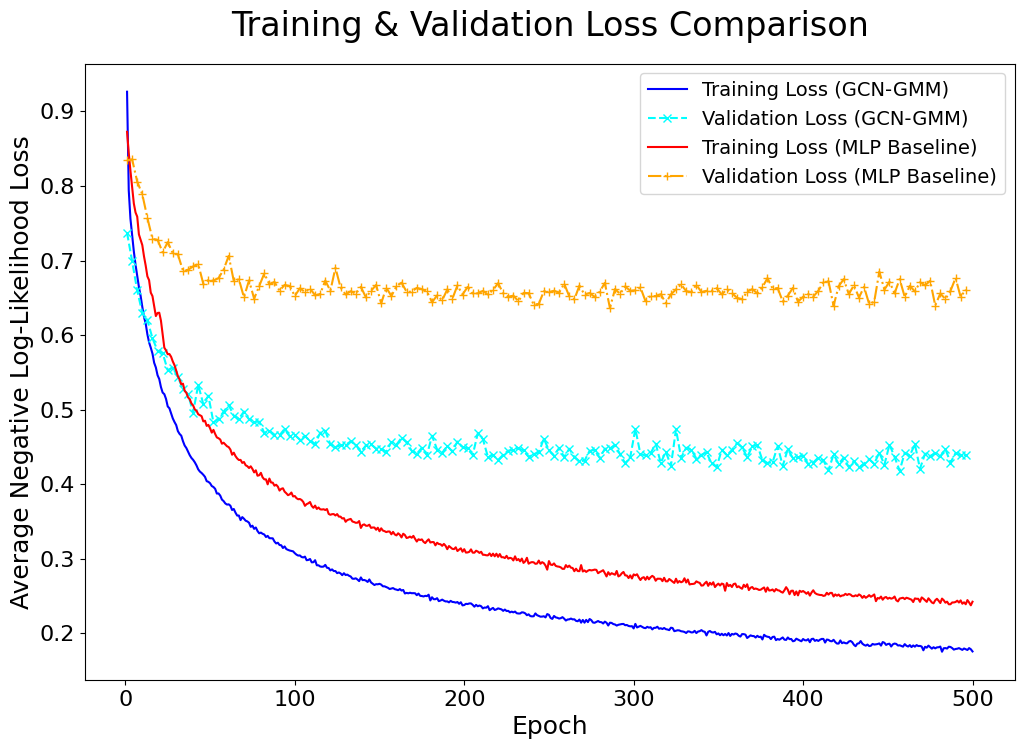

In [ ]:
plt.figure(figsize=(12, 8))

# GAT-GMM model
plt.plot(range(1, num_epochs + 1), train_losses, linestyle='-', label='Training Loss (GAT-GMM)', color='blue')
if val_losses:
    plt.plot(val_epochs, val_losses, marker='x', linestyle='--', label='Validation Loss (GAT-GMM)', color='cyan')
#MLP-GMM model
plt.plot(range(1, num_epochs + 1), train_losses_mlp, linestyle='-', label='Training Loss (MLP Baseline)', color='red')
if val_losses_mlp:
    plt.plot(val_epochs, val_losses_mlp, marker='+', linestyle='-.', label='Validation Loss (MLP Baseline)', color='orange')


plt.title("Training & Validation Loss Comparison", fontsize=24,pad=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Average Negative Log-Likelihood Loss", fontsize=18)
plt.legend(fontsize=14) # Display all labels
#plt.grid(True) # A grid is helpful for comparing multiple curves

# Adjust x-axis ticks
tick_interval = 100
# Ensure the stop value includes the last epoch number if it's on a tick
plt.xticks(np.arange(0, num_epochs + 1, tick_interval), fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# **Model Prediction**

### **Load Model**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mdn_input_dim = GAT_out_channels * 3
mdn_hidden_dim = 128
num_gaussians = 9

# Re-instantiate a model with exactly the same structure as during training
loaded_model = GATMDNModel(
    num_nodes_region=num_nodes_region, initial_feature_dim_region=initial_feature_dim_region,
    num_nodes_occupation=num_nodes_occupation, initial_feature_dim_occupation=initial_feature_dim_occupation,
    num_nodes_industry=num_nodes_industry, initial_feature_dim_industry=initial_feature_dim_industry,
    embedding_dim=embedding_dim, GAT_hidden_channels=GAT_hidden_channels, GAT_out_channels=GAT_out_channels,
    mdn_input_feature_dim=mdn_input_dim, mdn_hidden_dim=mdn_hidden_dim, num_gaussians=num_gaussians)

loaded_model.load_state_dict(torch.load('model_0703.pth'))

loaded_model.to(device)
loaded_model.eval()

GCNMDNModel(
  (gcn_region): GCNWithEmbedding(
    (node_embedding_layer): Embedding(420, 32)
    (conv1): GCNConv(452, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (gcn_occupation): GCNWithEmbedding(
    (node_embedding_layer): Embedding(2844, 32)
    (conv1): GCNConv(2876, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (gcn_industry): GCNWithEmbedding(
    (node_embedding_layer): Embedding(103, 32)
    (conv1): GCNConv(135, 64)
    (conv2): GCNConv(64, 32)
    (relu): ReLU()
  )
  (mdn_head): MDNHead(
    (fc_hidden): Linear(in_features=96, out_features=128, bias=True)
    (fc_pi): Linear(in_features=128, out_features=9, bias=True)
    (fc_sigma_sq_logits): Linear(in_features=128, out_features=9, bias=True)
    (fc_mu): Linear(in_features=128, out_features=9, bias=True)
  )
)

### **Prediction Function**

First, define the research group: give a series of screening conditions, such as region in Amsterdam or Utrecht, industry in Manufacturing or Retail, and occupation in ICT managers. Then it could predict an overall salary distribution for this screened group by defining a predict_group_distribution function.

In [ ]:
from itertools import product
from scipy.stats import norm
import pandas as pd
from scipy.stats import norm, lognorm

# Case insensitive when entering attribute names
def find_key_case_insensitive(data_dict, target_key):
    #key: existing attribute name target_key: input attribute name. Lowercase them all. If a match is found, enter the original existing attribute name"
    if pd.isna(target_key):
        return None #Avoid NAN

    target_key_lower = str(target_key).lower()
    for key in data_dict.keys():
        if str(key).lower() == target_key.lower():
            return key
    return None


def get_sample_count(value, attr_name, df):
    """
    Counts the total occurrences of a specific attribute 'value'
    across all relevant columns in the DataFrame 'df'.

    Args:
        value (str): The specific attribute value to count (e.g., 'Amsterdam').
        attr_name (str): The general category to search for (e.g., 'geo', 'industry').
        df (pd.DataFrame): The original data DataFrame to search within.

    Returns:
        int: The total count of rows where the value appears.
    """
    # 1. If the input value is None, there's nothing to count.
    if value is None:
        return 0

    # 2. Identify all possible columns in the DataFrame related to the attribute name.
    #    For example, if attr_name is 'geo', this will find 'geo_level_2_string', 'geo_level_4_string'.
    possible_cols = [col for col in df.columns if attr_name in col and col.endswith(('_name', '_string'))]

    if not possible_cols:
        print(f"Warning: No columns found for attribute type '{attr_name}'")
        return 0

    # 3. Find the actual, case-correct version of the 'value' as it exists in the data.
    #    This is important because 'amsterdam' and 'Amsterdam' should be treated the same.
    #    We create a temporary set of all unique values from the relevant columns to search in.
    all_unique_values_in_cols = pd.concat([df[col].dropna() for col in possible_cols]).unique()
    temp_mapping_dict = {str(v): str(v) for v in all_unique_values_in_cols}

    original_key = find_key_case_insensitive(temp_mapping_dict, value)

    # 4. If the key doesn't exist in the data at all, its count is 0.
    if not original_key:
        return 0

    # 5. Sum the occurrences of the original_key across all relevant columns.
    total_count = 0
    for col in possible_cols:
        # (df[col] == original_key) creates a boolean Series (True where match)
        # .sum() on a boolean Series counts the number of True values.
        total_count += (df[col] == original_key).sum()

    return total_count




In [ ]:
def predict_group_distribution(
    model,
    # --- User Inputs: Lists of strings ---
    region_names: list = None,
    industry_names: list = None,
    occupation_names: list = None,
):
    """
    Predicts both the weighted average salary and the aggregate salary
    distribution for a group, assuming the model was trained on
    log-transformed and standardized salary data.
    """
    print("\n--- Starting Group Prediction (for Log-Transformed Model) ---")

    # Ensure inputs are lists for itertools.product
    region_names = region_names if region_names else [None]
    industry_names = industry_names if industry_names else [None]
    occupation_names = occupation_names if occupation_names else [None]

    # 1. Generate all attribute combinations
    all_combinations = list(product(region_names, industry_names, occupation_names))
    print(f"Generated {len(all_combinations)} combination(s) to predict.")

    model.eval()
    predictions_data = [] # Will store parameters and weights for each combo

    # 2. Predict GMM parameters for each combination
    for combo in all_combinations:
        # ... (The logic to get node IDs for each combo remains the same as before)
        region_name, industry_name, occupation_name = combo
        geo_l2_idx, geo_l4_idx, occ_l1_idx, occ_l2_idx, occ_l6_idx, ind_l1_idx, ind_l2_idx = [-1]*7
        if region_name and region_name in G_region.nodes:
            node_type = G_region.nodes[region_name]['type']
            node_id = node_mapping_region.get(region_name, -1)
            if node_type == 'geo_level_2': geo_l2_idx = node_id
            elif node_type == 'geo_level_4': geo_l4_idx = node_id
        if occupation_name and occupation_name in G_occupation.nodes:
            node_type = G_occupation.nodes[occupation_name]['type']
            node_id = node_mapping_occupation.get(occupation_name, -1)
            if node_type == 'occupation_level_1': occ_l1_idx = node_id
            elif node_type == 'occupation_level_2': occ_l2_idx = node_id
            elif node_type == 'occupation_level_6': occ_l6_idx = node_id
        if industry_name and industry_name in G_industry.nodes:
            node_type = G_industry.nodes[industry_name]['type']
            node_id = node_mapping_industry.get(industry_name, -1)
            if node_type == 'industry_level_1': ind_l1_idx = node_id
            elif node_type == 'industry_level_2': ind_l2_idx = node_id
        geo_l2_idx_batch = torch.tensor([geo_l2_idx], dtype=torch.long, device=device)
        geo_l4_idx_batch = torch.tensor([geo_l4_idx], dtype=torch.long, device=device)
        occ_l1_idx_batch = torch.tensor([occ_l1_idx], dtype=torch.long, device=device)
        occ_l2_idx_batch = torch.tensor([occ_l2_idx], dtype=torch.long, device=device)
        occ_l6_idx_batch = torch.tensor([occ_l6_idx], dtype=torch.long, device=device)
        ind_l1_idx_batch = torch.tensor([ind_l1_idx], dtype=torch.long, device=device)
        ind_l2_idx_batch = torch.tensor([ind_l2_idx], dtype=torch.long, device=device)

        with torch.no_grad():
            log_pi, sigma_scaled, mu_scaled = model(x_initial_region_full, edge_index_region_full,
        geo_l2_idx_batch, geo_l4_idx_batch,
        x_initial_occupation_full, edge_index_occupation_full,
        occ_l1_idx_batch, occ_l2_idx_batch, occ_l6_idx_batch,
        x_initial_industry_full, edge_index_industry_full,
        ind_l1_idx_batch, ind_l2_idx_batch)

        # --- MODIFICATION: Correct inverse transform and expectation calculation ---
        pi = torch.exp(log_pi).squeeze(0).cpu().numpy()
        mu_scaled_np = mu_scaled.squeeze(0).cpu().numpy()
        sigma_scaled_np = sigma_scaled.squeeze(0).cpu().numpy()

        # Step A: Inverse-standardize to get parameters on the LOG-SCALE
        mu_log = salary_scaler.inverse_transform(mu_scaled_np.reshape(-1, 1)).flatten()
        sigma_log = sigma_scaled_np * salary_scaler.scale_[0]

        # Step B: Calculate the expected value for a Log-Normal Mixture
        # E[Y] = sum(pi_k * exp(mu_log_k + sigma_log_k^2 / 2))
        expected_salary_real = np.sum(pi * np.exp(mu_log + (sigma_log**2) / 2))
        # --------------------------------------------------------------------

        # Calculate weight for this combination
        weights = []
        if combo[0]: weights.append(get_sample_count(combo[0], 'geo', data))
        if combo[1]: weights.append(get_sample_count(combo[1], 'industry', data))
        if combo[2]: weights.append(get_sample_count(combo[2], 'occupation', data))
        weight = min(weights) if weights else 0

        predictions_data.append({
            'combination': combo,
            'predicted_salary': expected_salary_real, # Now this is the correct point estimate
            'pi': pi,
            'mu_log': mu_log,         # Store log-scale mu for plotting
            'sigma_log': sigma_log,   # Store log-scale sigma for plotting
            'weight': weight
        })

    # --- 3. Calculate Final Weighted Average and Aggregate Distribution ---
    # The weighted average calculation logic remains the same, but now uses the corrected salary
    total_weighted_salary_sum = 0
    total_weight = sum(p['weight'] for p in predictions_data)

    print("\n--- Individual Combination Predictions ---")
    for p in predictions_data:
        print(f"  Combination: {p['combination']}, Predicted E[Salary]: {p['predicted_salary']:.2f}, Weight: {p['weight']}")
        total_weighted_salary_sum += p['predicted_salary'] * p['weight']

    weighted_average_salary = 0
    if total_weight > 0:
        weighted_average_salary = total_weighted_salary_sum / total_weight
        print(f"\n--- Final Result ---")
        print(f"Weighted Average Predicted Salary: {weighted_average_salary:.2f}")
    else:
        pass

    # Plotting for Log-Normal Mixture
    if total_weight > 0:
        plot_min = max(0, weighted_average_salary - 3 * weighted_average_salary * 0.5)
        plot_max = weighted_average_salary + 3 * weighted_average_salary * 0.5
        x_plot = np.linspace(plot_min, plot_max, 1000)
        y_plot = np.zeros_like(x_plot)

        # Create the mixture of log-normal distributions
        for p in predictions_data:
            if p['weight'] > 0:
                combo_weight_normalized = p['weight'] / total_weight
                for i in range(len(p['pi'])):
                    pi_k = p['pi'][i]
                    mu_log_k = p['mu_log'][i]
                    sigma_log_k = p['sigma_log'][i]

                    y_plot += (combo_weight_normalized * pi_k) * lognorm.pdf(x_plot, s=sigma_log_k, scale=np.exp(mu_log_k))

        # final aggregate distribution
        plt.figure(figsize=(12, 7))
        plt.plot(x_plot, y_plot, label='Aggregate Predicted Salary Distribution (PDF)')
        plt.legend(fontsize=16)
        plt.title("Aggregate Salary Distribution for Selected Group",fontsize=22,pad=20)
        plt.xlabel("Predicted Salary (Real Value)",fontsize=18)
        plt.xlim(50000,60000)
        plt.ylim(0,0.003)
        plt.ylabel("Probability Density",fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.fill_between(x_plot, y_plot, alpha=0.2)
        plt.grid(True)
        plt.legend()
        plt.show()

    if total_weight > 0:
        plot_data = [p for p in predictions_data if p['weight'] > 0]

        if plot_data:
            labels = ['\n'.join(filter(None, p['combination'])) for p in plot_data]
            pi_values = np.array([p['pi'] for p in plot_data])
            num_combinations = len(plot_data)
            num_components = pi_values.shape[1]

            fig, ax = plt.subplots(figsize=(1.5,5))
            fig.subplots_adjust(right=0.70)

            bottoms = np.zeros(num_combinations)
            for i in range(0,num_components):
                component_weights = pi_values[:, i]
                ax.bar(labels, component_weights, bottom=bottoms, label=f'Component {i+1}')
                bottoms += component_weights

            ax.set_title('GMM Component Weights', fontsize=12, pad=10)
            ax.set_ylabel('Component Weight', fontsize=10)
            #ax.set_xlabel('Attribute Combination', fontsize=8)
            ax.set_ylim(0, 1)
            ax.legend(
            title='GMM Component',
            fontsize=8,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5)
           )

            #plt.xticks(rotation=45, ha='right', fontsize=12)
            plt.yticks(fontsize=8)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

    return predictions_data, weighted_average_salary

### **Make Prediction**

In [ ]:
prediction_parameters = {
    'region_names': ['UtrechT'],
    'industry_names': ['Overige specialistische zakelijke dienstverlening'],
    'occupation_names': ['Data Analyst']
}

**Baseline: LightGBM**

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# 假设您已经有了分割好的 train_df 和 val_df
# train_df, val_df = train_test_split(...)

# --- A. 特征工程：独热编码 ---
print("--- Preparing data for Gradient Boosting Machine ---")

# 1. 选择要用于预测的类别特征列
#    我们选择每个属性域中最具体的可用级别作为代表，这与您的模型逻辑一致
#    这里我们创建一个新的DataFrame，只包含这些代表性列
categorical_features = []
for _, row in train_df.iterrows():
    # 地区: 优先L4，否则L2
    region = row['geo_level_4_string'] if pd.notna(row['geo_level_4_string']) else row['geo_level_2_string']
    # 职业: 优先L6 -> L2 -> L1
    occupation = row['occupation_level_6_name'] if pd.notna(row['occupation_level_6_name']) else \
                 (row['occupation_level_2_name'] if pd.notna(row['occupation_level_2_name']) else row['occupation_level_1_name'])
    # 行业: 优先L2 -> L1
    industry = row['industry_2_name'] if pd.notna(row['industry_2_name']) else row['industry_1_name']

    categorical_features.append({
        'region': region,
        'occupation': occupation,
        'industry': industry
    })

train_features_df = pd.DataFrame(categorical_features, index=train_df.index)

# 对验证集做同样的处理
categorical_features_val = []
for _, row in val_df.iterrows():
    region = row['geo_level_4_string'] if pd.notna(row['geo_level_4_string']) else row['geo_level_2_string']
    occupation = row['occupation_level_6_name'] if pd.notna(row['occupation_level_6_name']) else \
                 (row['occupation_level_2_name'] if pd.notna(row['occupation_level_2_name']) else row['occupation_level_1_name'])
    industry = row['industry_2_name'] if pd.notna(row['industry_2_name']) else row['industry_1_name']

    categorical_features_val.append({
        'region': region,
        'occupation': occupation,
        'industry': industry
    })

val_features_df = pd.DataFrame(categorical_features_val, index=val_df.index)

# 2. 使用 pd.get_dummies 进行独热编码
X_train_lgbm = pd.get_dummies(train_features_df, dummy_na=True, sparse=False).astype(int)
X_val_lgbm = pd.get_dummies(val_features_df, dummy_na=True, sparse=False).astype(int)

# 统一列，确保验证集和训练集的特征列完全一致
# 验证集中可能出现训练集中没有的类别，反之亦然
common_cols = list(set(X_train_lgbm.columns) & set(X_val_lgbm.columns))
X_train_lgbm = X_train_lgbm[common_cols]
X_val_lgbm = X_val_lgbm[common_cols]

# 3. 准备目标变量 (y)
#    GBM也应该在对数转换和标准化后的薪酬上进行训练，以保证公平比较
y_train_lgbm = train_df['log_average_scaled'].values
y_val_lgbm = val_df['log_average_scaled'].values

print(f"LGBM training features shape: {X_train_lgbm.shape}")
print(f"LGBM validation features shape: {X_val_lgbm.shape}")

--- Preparing data for Gradient Boosting Machine ---


NameError: name 'train_df' is not defined


--- Starting Group Prediction (for Log-Transformed Model) ---
Generated 1 combination(s) to predict.

--- Individual Combination Predictions ---
  Combination: ('UtrechT', 'Overige specialistische zakelijke dienstverlening', 'Data Analyst'), Predicted E[Salary]: 115194.58, Weight: 456

--- Final Result ---
Weighted Average Predicted Salary: 115194.58


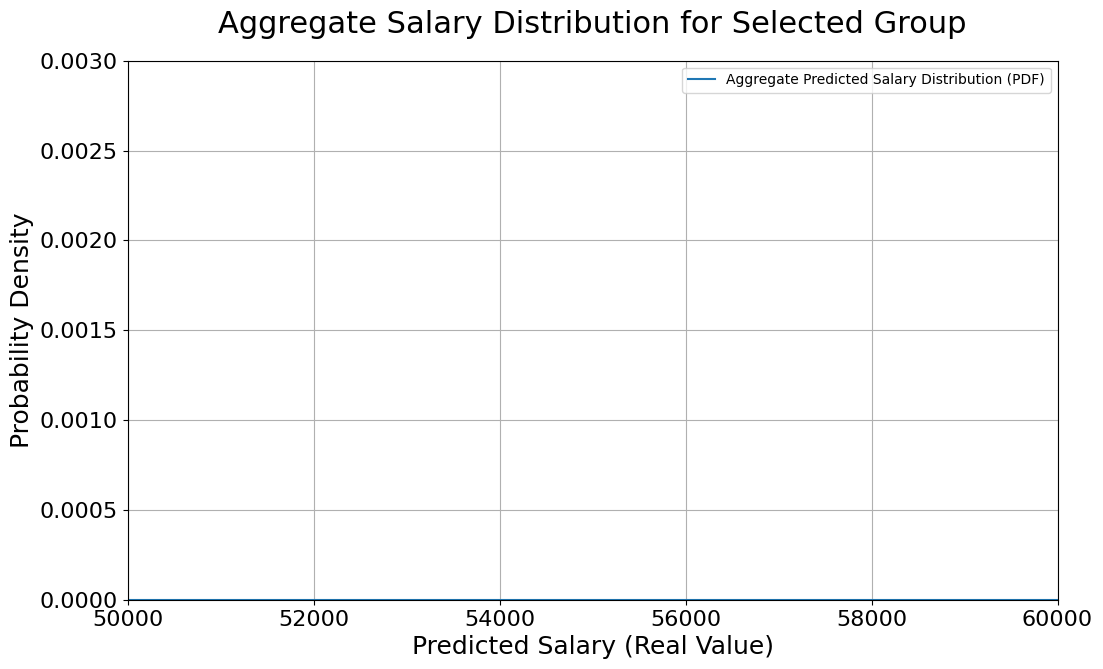

/tmp/ipython-input-148-2816780236.py:181: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


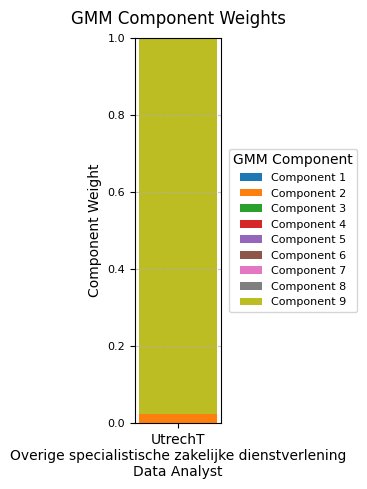

([{'combination': ('UtrechT',
    'Overige specialistische zakelijke dienstverlening',
    'Data Analyst'),
   'predicted_salary': np.float64(115194.57536700176),
   'pi': array([2.2178720e-20, 2.2342736e-02, 1.7763670e-14, 2.8160186e-15,
          2.3455550e-11, 1.9338138e-12, 1.7754655e-05, 6.8433981e-19,
          9.7763956e-01], dtype=float32),
   'mu_log': array([15.54416  , 11.161528 , 11.221985 ,  9.90833  , 11.447894 ,
          11.0540085, 10.510998 , 12.216228 , 11.663229 ], dtype=float32),
   'sigma_log': array([4.90612740e-03, 3.93354828e-03, 6.02847078e+00, 9.06086825e-03,
          3.93354828e-03, 3.93354828e-03, 3.93354828e-03, 3.93354828e-03,
          5.22118403e-03]),
   'weight': np.int64(456)}],
 np.float64(115194.57536700176))

In [ ]:
predict_group_distribution(
    model=loaded_model,
    **prediction_parameters)